# Detecting Potential Candidates Who are Looking for New Job

# 1  Introduction
Company XYZ is a training institute which conducts training for analytics/ data science. They want to expand their business to manpower recruitment (data science only) by connecting their enrollees with their clients who are looking to hire employees working in the same domain. Before that, they want to know among the large number of signups, which of these candidates are looking for a new employment. To understand the factors that lead the enrollees to look for a job change, Company XYZ wants to build a model based on the current credentials/demographic/experience data they collected from the enrollee to predict the probability of them to look for a new job. By identifying the target enrollee (potential candidate) as many as possible from all enrollee registered on the training platform, the recruiting team in company XYZ could take further approach to their targets more efficiently and effectively. 

## 1.1 Objective
The objectives of this project are:
- To explore and analyze enrollee data for XYZ training institute 
- To identify the key features that lead the enrollee to look for new employment.
- To develop machine learning models that predict the probability of enrollee looking for a new job
- To identify the final model that captures the most target enrollees within the top 20% of the test dataset ordered by their predicted probability 

## 1.2 Significance 
By thoroughly explore the dataset, we will identify the important features that affect the enrollee’s decision of career change. We will also develop machine learning models that can be used by the recruiting team of company XYZ to filter out the potential candidates from the user data base and approach them with better efficiency and accuracy.

# 2 Dataset

## 2.1 Data Description 
The datasets are sourced from the website kaggle, a subsidiary of Google LLC, is an online community of data scientists and machine learning practitioners that allows users to find and publish datasets, explore and build models in a web-based data-science environment. The dataset train.csv used in this project, was collected on August 12, 2020.  It consists of 18,359 rows and 14 columns, 4 of them are numerical columns and 10 of them are categorical columns.  Each row contains credentials/demographic/experience data for each unique enrollee. A description of each of the 14 columns can be found below.

|No.|Variable name|Variable description|Data summary|
|------|------|------|------|
|1|enrollee_id|unique ID for enrollees|integer, 18359 unique values|
|2|city|city code|object, 123 unique values|
|3| city_development_index | Developement index of the city (scaled) | continuous, 93 unique values |
|4| gender | gender | object, 3 unique values |
|5| relevent_experience | relevant experience in analytics, data science  | object, 2 unique values |
|6| enrolled_university | type of University course enrolled if any  | object, 3 unique values |
|7| education_level | education level  | object, 5 unique values |
|8| major_discipline | major discipline  | object, 6 unique values |
|9| experience | total working experience in years  | object, 22 unique values |
|10| company_size | number of employees in current employer's company  | object, 8 unique values |
|11| company_type | type of current employer  | object, 6 unique values |
|12| last_new_job | difference in years between previous job and current job  | object, 6 unique values |
|13| training_hours | training hours completed  | integer, 241 unique values |
|14| target | looking for job change or not  | integer; 0=not looking for job change, 1=Looking for a job change |

## 2.2 Dataset Characteristic: Class Imbalance and Feature Space Overlap
An inherent characteristic of this dataset is its class imbalance. In the original dataset train.csv, there is 15,934 negative classes and 2425 positive classes in column ‘target’. Value 0 represents the negative class which means the enrollee is not open for career change, we will define this class as ‘non-Target’ enrollee in this study. While value 1 represents the positive class, means the enrollee is open for career change, we will define this class ‘Target’ enrollee in this study, using capitalized ‘Target’ to distinguish it from column ‘target’. 
After analyze the dataset we notice there's an approximately 6:1 ratio of non-Target enrollee to Target enrollee. And this causes the baseline models to be overly insensitive when predict Target enrollee. Most of the models misclassify almost all the positive class (Target enrollee) in the test set (the baseline models’ recall on Target enrollee is very low). Therefore we will address this issue in the further section (Section 5) with oversampling technique. 
Another issue of this dataset is high degree of feature overlap between classes. Many Target enrollee have feature values that are very similar to feature values of non-Target enrollee. This could bring difficulty for the models to predict Target enrollee with high precision.


# 3 Package Introduction

# 4 Data Wrangling

## 4.1 Imports & Setup

In [1]:
# load basic libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [3]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


## 4.2 Loda Data

In [4]:
df = pd.read_csv('data/train.csv')

In [5]:
df.shape

(18359, 14)

In [6]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


## 4.3 Data Overall Info
<b>Count of unique values, NaN value percentage, data type</b>

In [7]:
# creata a function to calculate unique value count and percentage for the whole dataset
# and check the data type for each column
def data_info(data):
    count = data.nunique()
    va_pct = round(count/(data.shape[0])*100,2)
    nan_p = round(data.isnull().sum()/data.shape[0]*100,2)
    frame = pd.DataFrame(zip(count,va_pct,nan_p), index=count.index, 
                         columns=['counts','unique_value_pct', 'nan_pct']).reset_index().rename(columns={'index': 'column'})
    
  
    frame['data_type']= df.dtypes.tolist()
    return frame.sort_values('counts', ascending=False)

In [8]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.00,int64
12,training_hours,241,1.31,0.00,int64
1,city,123,0.67,0.00,object
2,city_development_index,93,0.51,0.00,float64
8,experience,22,0.12,0.32,object
9,company_size,8,0.04,26.03,object
7,major_discipline,6,0.03,15.46,object
10,company_type,6,0.03,27.45,object
11,last_new_job,6,0.03,2.00,object
6,education_level,5,0.03,2.49,object


## 4.4 Label Breakdown (class imbalance)

In [9]:
# create a function to check the value_counts and value_counts ratio/pct for each variable 
def var_pct(data, column):
    count = data.value_counts(dropna=False)
    pct = round(count/(data.shape[0])*100,2)
    frame = pd.DataFrame(zip(count,pct), index=count.index, 
                         columns=['counts','pct']).reset_index().rename(columns={'index': column})
    
    return frame.sort_values('pct',ascending=False)

In [10]:
# Call function var_pct() on column 'target', enrollee who is open to a new employment is labeled as 1
df_target = var_pct(df['target'], 'label')
df_target['label']=['non-Target', 'Target']
df_target

,label,counts,pct
0,non-Target,15934,86.79
1,Target,2425,13.21


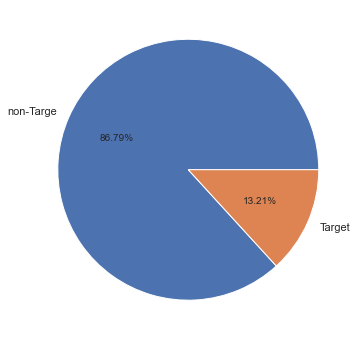

In [11]:
# label 1 is also considered as 'target' in this dataset, label 0 is considered as 'non-Target'

# Let's check the percentage in a pie graph, we can see the ratio of value 1 and 0 is about 1:6. 
df_target = var_pct(df['target'], 'label')
plt.figure(figsize=(8,6))
plt.pie(df_target.counts, labels= ['non-Targe', 'Target'], autopct='%.2f%%')
plt.show()

## 4.5 Feature Space Overlap

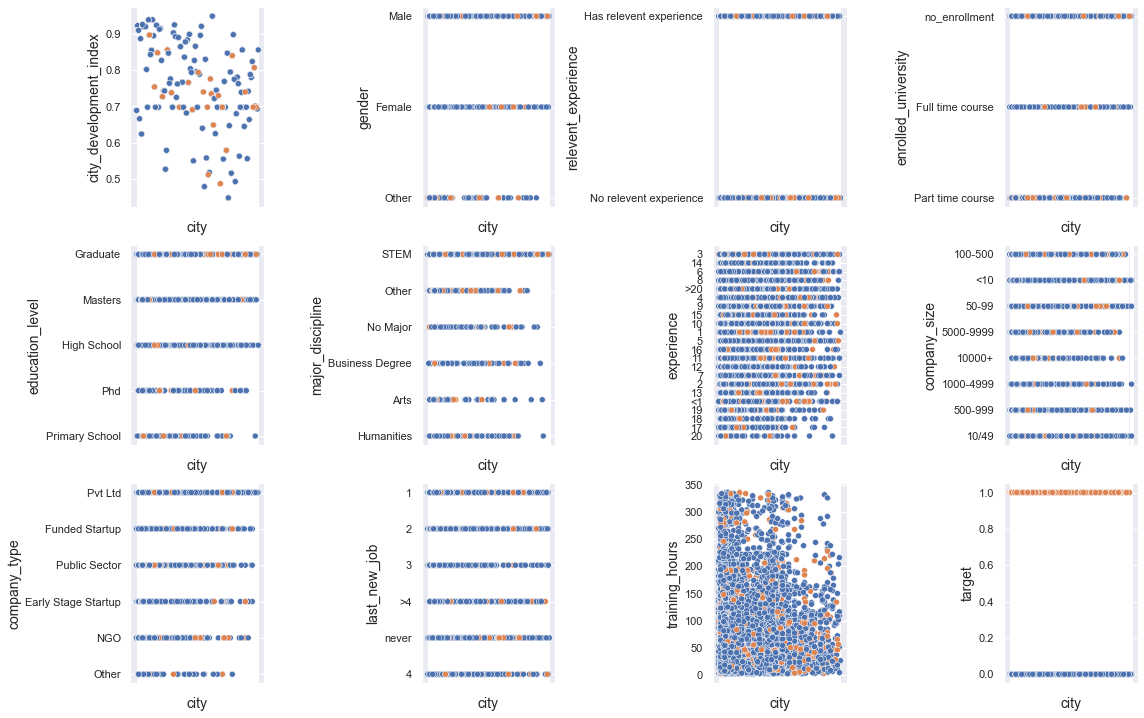

In [12]:
# All variables (except ‘enrollee_id’) plotted against variable ‘city’. 
# Target enrollee are plotted in orange, non-Target enrollee are plotted in blue. 

allcol = ['city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'city', 'last_new_job', 'training_hours', 'target']

fig = plt.figure(figsize=(16,13))


d = 0 
k = 0
for i in range(len(allcol)):
    features = ['city',allcol[k]]
    if features[1] == 'city':
        k += 1
        d -= 1
        continue
    
    ax = fig.add_subplot(4,4,i+1+d)
    ax = sns.scatterplot(data=df, x=features[0], y=features[1], hue='target', legend=False)
    ax.set_ylabel(features[1],fontsize=14)
    ax.set_xlabel(features[0],fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    k += 1
    

plt.tight_layout()

By plotting different combination of variables onto two dimensional spaces, we can observe a lack of distinction between Target enrollee (orange) and non-Target enrollee (blue). 
<br>In the figure above,  the 2 classes can be seen to have almost indistinguishable distributions across various variables. 

## 4.6 Detecting Missing Values

In [13]:
data_info(df)[data_info(df).nan_pct !=0].sort_values('nan_pct', ascending=False)

,column,counts,unique_value_pct,nan_pct,data_type
10,company_type,6,0.03,27.45,object
9,company_size,8,0.04,26.03,object
3,gender,3,0.02,22.32,object
7,major_discipline,6,0.03,15.46,object
6,education_level,5,0.03,2.49,object
11,last_new_job,6,0.03,2.00,object
5,enrolled_university,3,0.02,1.86,object
8,experience,22,0.12,0.32,object


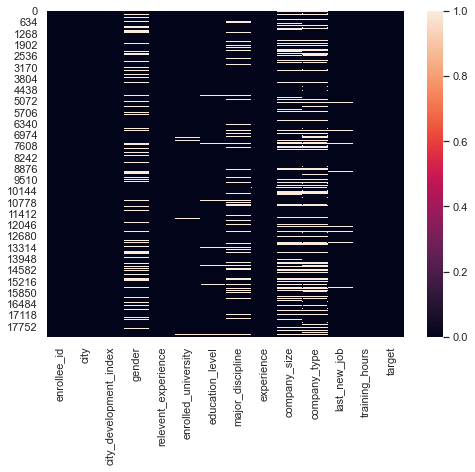

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull(), cbar=True)
plt.show()

## 4.7 Variable Grouping

Besides 'enrollee_id' and 'target',  we can group the rest of the 12 variables to 6 groups based on the variables' features.
<br>We then choose the optimal data processing method for each group based on their data characteristics.

| Group | Variable feature | Variable names | Variable with Missing values | Process |
|------|------|------|------|------|
|   Group 1  | experience related variables| relevent_experience, experience, last_new_job | experience, last_new_job | data type correction, missing value imputation (fill with mode) |
|   Group 2  | employer related variables| company_type, company_size | company_type, company_size | data grouping, missing value imputation  (fill with KNN imputation |
|   Group 3  | education related variables| education_level, major_discipline,  enrolled_university | education_level, major_discipline,  enrolled_university  | data grouping, data type correction, missing value imputation (fill with 0 and mode) |
|   Group 4  | gender | gender | gender | data type correction, missing value imputation (fill with mode) |
|   Group 5  | city related variables | city, city_development_index | - | data grouping, data type correction |
|   Group 6  | training related variables | training_hours | - | - |

### <b>4.7.1 Group 1: Experience Related Variables</b>
<b>relevent_experience, experience, last_new_job</b>
- (1) Variable correlation
- (2) Variable breakdown
- (3) Data type correction and missing value imputation (fill with mode)

### (1) Variable correlation between <b>relevent_experience, last_new_job, experience</b>

In [15]:
# create a func to make scatter plot between multiple variables when there are more than 2 of them.
def multi_scatterplot(group, n):
    plt.figure(figsize=(14,6))
    for i, k in enumerate((group),1):
        plt.subplot(1,len(group),i)
        if i <=2 :
            features=[group[i-1], group[i]]
            ax = sns.scatterplot(data=df, x=features[0], y=features[1])
            #ax.legend(['non-Target', 'target'])
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=n)
            
        else:
            features=[group[i-3], group[i-1]]
            ax = sns.scatterplot(data=df, x=features[0], y=features[1])
            locs, labels = plt.xticks()
            plt.setp(labels, rotation=n)
    
    
    plt.tight_layout()



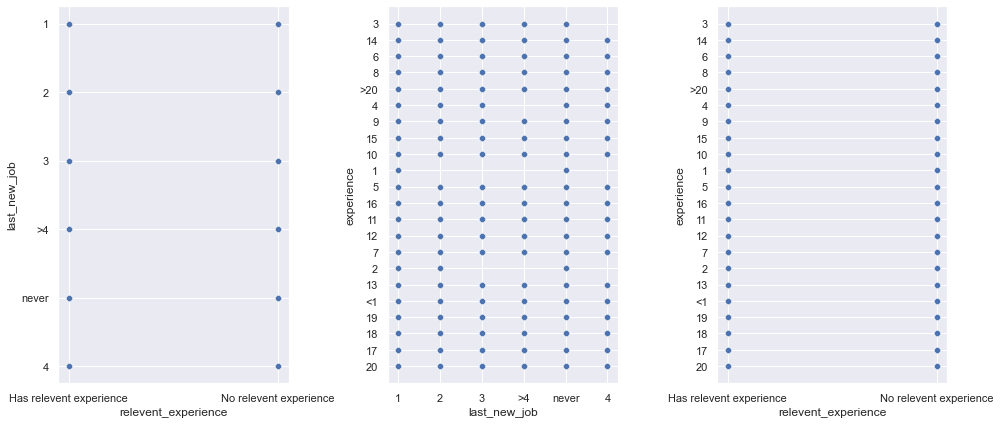

In [16]:
# plot the scatterplot between 3 variables
group1 = ['relevent_experience', 'last_new_job', 'experience']
multi_scatterplot(group1, 0)

Based on the data feature we should notice 2 problems with values in experience and last_new_job by looking at the scatter plot above. 
- 1. While 'experience' (total working experience in year) value is <1, 'last_new_job' (difference in years between previous job and current job) value should only be either 'never' or 1, however it also contains value 2, 3, 4, >4;
- 2.  While 'experience' value is 3, 'last_new_job' value should be either 'never' or 1 or 2 or 3, however it also contains value 4 or >4

which are theoretically impossible. This could have been caused by value mis-input, mis-calculating or enrollee forgot to update 'experience' column when updated their information in 'last_new_job' column. We will fix this data problem through updating the 'experience' value by adding up the 'last_new_job' value with the experience value. 

### (2) Variable breakdown (unique value counts, percentage, missing value percentage)

In [17]:
var_pct(df.relevent_experience, 'relevent experience')

,relevent experience,counts,pct
0,Has relevent experience,13596,74.06
1,No relevent experience,4763,25.94


In [18]:
var_pct(df.experience, 'experience')

,experience,counts,pct
0,>20,3437,18.72
1,5,1309,7.13
2,4,1250,6.81
3,3,1159,6.31
4,6,1125,6.13
5,2,992,5.40
6,9,979,5.33
7,10,967,5.27
8,7,950,5.17
9,8,755,4.11


In [19]:
var_pct(df.last_new_job, 'last_new_job')

,last_new_job,counts,pct
0,1,7567,41.22
1,>4,3339,18.19
2,2,2835,15.44
3,never,2186,11.91
4,4,1038,5.65
5,3,1027,5.59
6,NaN,367,2.00


### (3) Data type correction and missing value imputation

As 'experience' and 'last_new_job' value are correlated and they both have missing values, 
so we can not simply fill each variable with their most frequent value or use KNN imputation.

Therefore the process we will take for this group is:

- 1) replace categorical values and convert data type in variables 'experience', 'last_new_job', from data type 'object' to 'float'
- 2) replace categorical value in variable 'relevent_experience', 'No relevent experience' will be replaced by 0, 'Has relevent experience' will be replaced by 1, convert data type to float
- 3) fill missing value in 'experience' with the most frequent value '>20', fill missing value in 'last_new_job' with the most frequent value '1'. As the missing values in these two variables are both lower than 3%, therefor fillna with the most frequent value will not create too much bias.
- 4) filter out rows where 'last_new_job' > 'experience' and correct the value in last_new_job by replacing it with experience value in that row

In [20]:
# create a function to do 1) ~ 2)
def feature_en_group1(data):
    data.experience = data.experience.map(lambda x: '0' if x == '<1'
                                  else '21' if x == '>20'
                                  else x if x is not None
                                  else None).astype('float')
    
    data.last_new_job = data.last_new_job.map(lambda x: '0' if x == 'never' 
                                      else '5' if x == '>4'
                                      else x if x is not None
                                      else None).astype('float')
    
    data.relevent_experience = data.relevent_experience.map(lambda x: '0' if x=='No relevent experience'
                                                   else '1').astype('float')

    
feature_en_group1(df)

In [21]:
df[(df.last_new_job > df.experience)]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
135,12796,city_16,0.910,NaN,0.0,Full time course,High School,NaN,0.0,10/49,Pvt Ltd,2.0,58,0
245,33277,city_11,0.550,NaN,0.0,no_enrollment,Masters,STEM,0.0,NaN,NaN,1.0,12,1
246,14456,city_21,0.624,Female,1.0,Full time course,Graduate,STEM,0.0,50-99,Pvt Ltd,1.0,33,1
252,24144,city_28,0.939,Male,1.0,Part time course,High School,NaN,3.0,5000-9999,Pvt Ltd,5.0,166,0
261,12263,city_16,0.910,Male,1.0,no_enrollment,Graduate,Humanities,3.0,NaN,NaN,5.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17785,2027,city_21,0.624,Male,0.0,no_enrollment,Graduate,Other,0.0,NaN,NaN,1.0,167,0
17800,25564,city_103,0.920,Male,1.0,Full time course,Graduate,STEM,0.0,50-99,NaN,1.0,53,0
17954,24883,city_114,0.926,Male,0.0,no_enrollment,Graduate,STEM,0.0,NaN,NaN,5.0,41,0
17991,2530,city_149,0.689,Male,0.0,Full time course,Graduate,STEM,0.0,10/49,Pvt Ltd,1.0,43,0


In [22]:
# create a function to do 3) ~ 4) 
def fill_na_group1(data, a, b):
    data[a].fillna(data[a].mode()[0], inplace=True)
    data[b].fillna(data[b].mode()[0], inplace=True) 
    
    to_modify = df[a]
    replacements = []
    for i, j in zip(df[a], df[b]):
        if j>i:
            replacements.append(i+j)
    # if last_new_job value is bigger than experience value then update experience value by adding the last_new_job value on it.

    indexes = df[(df[b]>df[a])].index.tolist()

    for (index, replacement) in zip(indexes, replacements):
        to_modify[index] = replacement


In [23]:
fill_na_group1(df, 'experience', 'last_new_job')

In [24]:
# confirm that after the data processing, all the last_new_job value is equal or smaller than experience value.
df[(df.last_new_job>df.experience)]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target


### <b>4.7.2 Group 2: Employer related variables</b>
<b>company_type, company_size</b>
- (1) Variable correlation
- (2) Variable breakdown
- (3) Data grouping, data type correction and missing value imputation (fill with KNN imputation)

### (1) Variable correlation between <b>company_type, company_size</b>

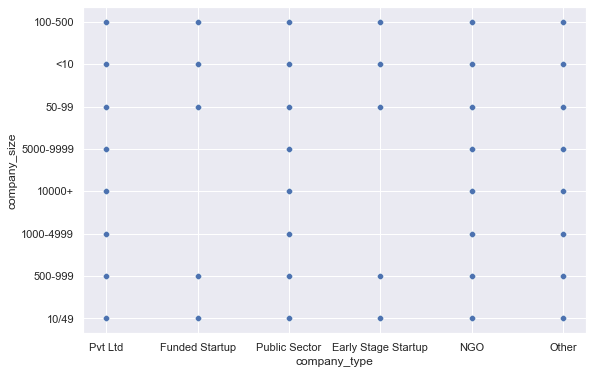

In [25]:
fig, ax = plt.subplots(figsize=(9,6))
sns.scatterplot(data=df, x='company_type', y='company_size')
plt.show()

<font color='red'>As we can see from the scatter plot, when company type is Funded Startup or Early Stage Startup, company_size will not be bigger than 1000. This information will help us with missing value imputation later.</font>

### (2) Variable breakdown (unique value counts, percentage, missing value percentage)

In [26]:
var_pct(df.company_type, 'company_type')

,company_type,counts,pct
0,Pvt Ltd,10051,54.75
1,NaN,5039,27.45
2,Funded Startup,1038,5.65
3,Public Sector,996,5.43
4,Early Stage Startup,582,3.17
5,NGO,534,2.91
6,Other,119,0.65


In [27]:
var_pct(df.company_size, 'company_size')

,company_size,counts,pct
0,NaN,4779,26.03
1,50-99,3120,16.99
2,100-500,2698,14.70
3,10000+,2044,11.13
4,10/49,1466,7.99
5,1000-4999,1399,7.62
6,<10,1360,7.41
7,500-999,902,4.91
8,5000-9999,591,3.22


### (3) Data grouping, data type correction and missing value imputation (fill with KNN)

- 1) group values in company_type
- 2) group values in company_size
- 3) fill missing value by using KNN imputation to avoid bias as missing value ratio in these 2 variables are higher than 25%

In [28]:
# create a func to do 1) ~ 2)
def feature_en_group2(data):
    
    data.company_type = data.company_type.map(lambda x: '1' if x in ['Funded Startup', 'Early Stage Startup'] 
                                      else '2' if x in ['Public Sector', 'NGO', 'Other']
                                      else '3' if x == 'Pvt Ltd'
                                      else None)
     
    
    data.company_size = data.company_size.map(lambda x: '1' if x in ['<10','10/49','50-99'] 
                                      else '2' if x in['100-500', '500-999'] 
                                      else '3' if x in ['1000-4999', '5000-9999', '10000+']
                                      else None)
    
feature_en_group2(df)

In [29]:
# create a func to do 3) 
from sklearn.impute import KNNImputer

def fill_na_group2(data, a, b):
    imputelist_1 = [a, b]
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    data[imputelist_1] = imputer.fit_transform(data[imputelist_1])
    
    # make sure after imputation, when company_type is 1(startup), company_size will not be bigger to 3.
    max_b_size = df.loc[df[a]==1][b].value_counts().index.max()
    if max_b_size != 3:
         data[imputelist_1] = round(data[imputelist_1])
    else:
        print('error: company_size should not be bigger than 3 when company_type is 1')
        

fill_na_group2(df, 'company_type', 'company_size')

### <b>4.7.3 Group 3: Education related variables</b>
<b>education_level, major_discipline, enrolled_university </b>
- (1) Variable correlation
- (2) Variable breakdown
- (3) Data grouping, data type correction and missing value imputation (fill with 0 and mode)


### (1) Variable correlation between <b>education_level, major_discipline</b>

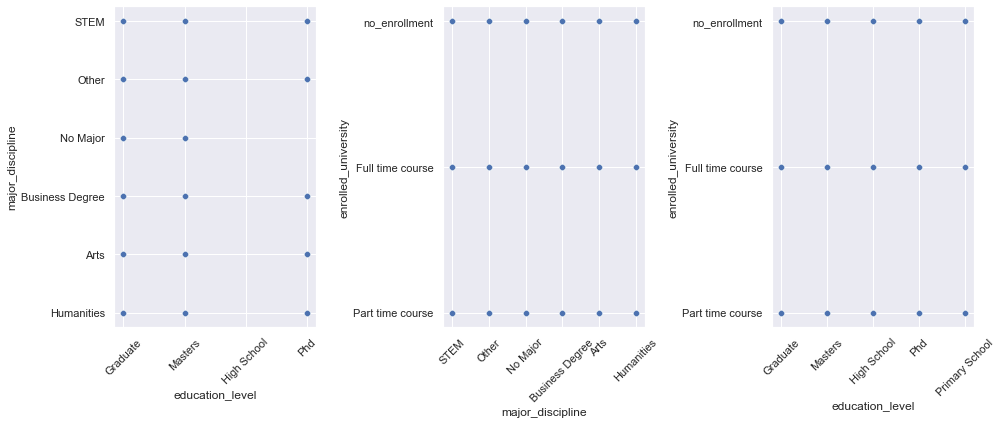

In [30]:
group3=['education_level', 'major_discipline', 'enrolled_university']

multi_scatterplot(group3, 45)

In [31]:
df[(df.education_level=='Primary School')|(df.education_level=='High School')].major_discipline.value_counts()

Series([], Name: major_discipline, dtype: int64)

<font color='red'><b>We realize when education_level equals to 'Primary School' or  'High School', there's no value in major_discipline
<br>This information will help us with missing value imputation later.</b></font>

### (2) Variable breakdown (unique value counts, percentage, missing value percentage)

In [32]:
var_pct(df.education_level, 'education_level')

,education_level,counts,pct
0,Graduate,10769,58.66
1,Masters,4319,23.53
2,High School,2032,11.07
3,Phd,459,2.50
4,NaN,457,2.49
5,Primary School,323,1.76


In [33]:
var_pct(df.major_discipline, 'major_discipline')

,major_discipline,counts,pct
0,STEM,13738,74.83
1,NaN,2838,15.46
2,Humanities,688,3.75
3,Other,343,1.87
4,Business Degree,307,1.67
5,Arts,239,1.30
6,No Major,206,1.12


In [34]:
var_pct(df.enrolled_university, 'enrolled_university')

,enrolled_university,counts,pct
0,no_enrollment,13659,74.40
1,Full time course,3187,17.36
2,Part time course,1171,6.38
3,NaN,342,1.86


### (3) Data grouping, data type correction and missing value imputation (fill with 0 and mode)

- 1) group values in education_level, correct data type 
- 2) group values in major_discipline, correct data type
- 3) group values in enrolled_university, correct data type
- 3) fill missing value in education_level with value 0 represents 'None', as missing value percentage is lower than 3%.
- 4) fill missing value in enrolled_university with most frequent value 'no_enrollment' as as missing value percentage is lower than 3% 
- 5) fill missing value in major_displine with value 0 when education_level is 'Primary school' and 'High school', fill the rest of the missing value with the most frequent value 'STEM', as there is only 26 NaN value left.

In [35]:
# create a func to do 1) ~ 3)
def feature_en_group3(data):
    
    data.education_level = data.education_level.map(lambda x: '1' if x in ['Primary School','High School']
                                           else '2' if x == 'Graduate'
                                           else '3' if x in ['Masters', 'Phd']
                                           else None).astype('float')
     
    
    data.major_discipline = data.major_discipline.map(lambda x: '2' if x == 'STEM' 
                                              else '1' if x in ['Humanities','Other','Business Degree', 'Arts']
                                              else 0 if x == 'No Major'
                                              else None).astype('float')
    
    data.enrolled_university = data.enrolled_university .map(lambda x: '0' if x=='no_enrollment'
                                                    else '1' if x in ['Full time course', 'Part time course']
                                                    else None).astype('float')
    
feature_en_group3(df)

In [36]:
# create func to do 3) ~ 5)
def fill_na_group3(data, a, b, c):
    data[a].fillna(0, inplace=True)
    data[c].fillna(data[c].mode()[0], inplace=True) 
    
    
    # when education level is none (0) or [primary school, high school] (1), fill major_discipline with value 0
    for i in [0,1]:
        data.loc[data[a]==i, b]=0
    # fill the rest of the 26 NaN value with the most frequent value in major_discipline
    data[b].fillna(data[b].mode()[0], inplace=True) 


fill_na_group3(df, 'education_level', 'major_discipline', 'enrolled_university')

### <b>4.7.4 Group 4: Gender</b>
<b>gender</b>
- (1) Variable breakdown
- (2) Data type correction and missing value imputation (fill with mode)

### (1) Variable breakdown (unique value counts, percentage, missing value percentage)


In [37]:
var_pct(df.gender, 'gender')

,gender,counts,pct
0,Male,12884,70.18
1,NaN,4098,22.32
2,Female,1188,6.47
3,Other,189,1.03


### (2) Data type correction and missing value imputation

- 1) replace 'Male' with value 1, 'Female' with value 2, 'Others' with value 3
- 2) fill missing value with the most frequent value in this variable, as missing value ration is lower than 25%

In [38]:
# create a func to do 1) ~ 2)
def feature_en_fiina_group4(data):
    
    data.gender = data.gender.map(lambda x: '1' if x == 'Male' 
                         else '2' if x == 'Female'
                         else '3' if x == 'Other'
                         else None).astype('float')
     
    
    data.gender.fillna(data.gender.mode()[0], inplace=True)
    
feature_en_fiina_group4(df)

### <b>4.7.5 Group 5: City related variables</b>
<b>city, city_development_index</b>

- (1) Variable correlation
- (2) Variable breakdown
- (3) Data grouping


### (1) Variable correlation between <b>city, city_development_index</b>

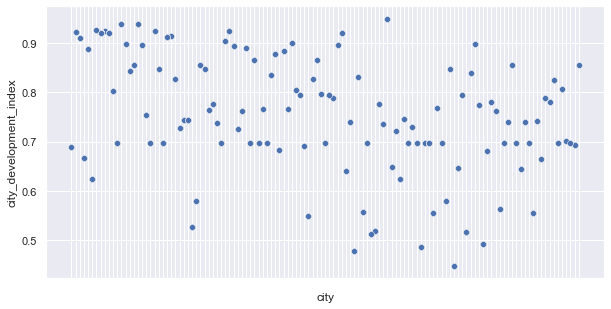

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(data=df, x='city', y='city_development_index')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

### (2) Variable breakdown (unique value counts, percentage, missing value percentage)

In [40]:
# check the value_counts pct for top 10 cities.
var_pct(df.city,'city').nlargest(10,'pct')

,city,counts,pct
0,city_103,4358,23.74
1,city_21,1672,9.11
2,city_16,1654,9.01
3,city_114,1472,8.02
4,city_160,827,4.50
5,city_136,624,3.40
6,city_67,455,2.48
7,city_75,332,1.81
8,city_104,318,1.73
9,city_102,313,1.70


In [41]:
var_pct(df.city_development_index, 'city_development_index').nlargest(10,'pct')

,city_development_index,counts,pct
0,0.920,5185,28.24
1,0.624,1672,9.11
2,0.910,1654,9.01
3,0.926,1472,8.02
4,0.698,655,3.57
5,0.897,624,3.40
6,0.939,544,2.96
7,0.855,455,2.48
8,0.924,318,1.73
9,0.804,313,1.70


### (3) Data grouping 

- 1) group variable 'city'. If the city's value_count ratio is greater than 1.7%, drop 'city_' only keep the city number. 
- 2) if the city's value_count ratio is lower than 1.7%, rename the city name to 'Others'
<br>*process 1) ~ 2) will help later when we dummy encode variable 'city', avoid the increase in data dimensionality, as after grouping the unique value in variable 'city' decreased from 123 to 11*

In [42]:
def feature_en_group5(data):
    data.city = data.city.map(lambda x: x.split('_')[1] if (df['city']==x).sum()/df.shape[0]*100 >= 1.7
                      else 'others').astype('str')

feature_en_group5(df)

### <b>4.7.6 Group 6: Training related variable</b>
<b>training_hours</b>:
For this group we don't need to do anything as there's no missing value and the data type is int64

## 4.8 Final Data Type Correction

In [43]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
0,enrollee_id,18359,100.00,0.0,int64
12,training_hours,241,1.31,0.0,int64
2,city_development_index,93,0.51,0.0,float64
8,experience,22,0.12,0.0,float64
1,city,11,0.06,0.0,object
11,last_new_job,6,0.03,0.0,float64
6,education_level,4,0.02,0.0,float64
3,gender,3,0.02,0.0,float64
7,major_discipline,3,0.02,0.0,float64
9,company_size,3,0.02,0.0,float64


In [44]:
# We will not use enrolle_id as predictor, so drop this column from the dataset
df = df.drop('enrollee_id',axis=1)

In [45]:
# check the columns that are not float.
cat_col=data_info(df)[data_info(df).data_type=='object'].column.tolist()
int_col = data_info(df)[data_info(df).data_type=='int64'].column.tolist()
print("categorical list is:", cat_col)
print("int64 columns are: ", int_col)

categorical list is: ['city']
int64 columns are:  ['training_hours', 'target']


In [46]:
# convert all the int variables to data type float
df[int_col] = df[int_col].astype('float')

In [47]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
11,training_hours,241,1.31,0.0,float64
1,city_development_index,93,0.51,0.0,float64
7,experience,22,0.12,0.0,float64
0,city,11,0.06,0.0,object
10,last_new_job,6,0.03,0.0,float64
5,education_level,4,0.02,0.0,float64
2,gender,3,0.02,0.0,float64
6,major_discipline,3,0.02,0.0,float64
8,company_size,3,0.02,0.0,float64
9,company_type,3,0.02,0.0,float64


# 5 Exploratory data analysis (EDA)

## 5.1 Summary Statistics

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
city_development_index,18359.0,0.847140,0.110189,0.448,0.796,0.91,0.92,0.949
gender,18359.0,1.085299,0.314034,1.000,1.000,1.00,1.00,3.000
relevent_experience,18359.0,0.740563,0.438338,0.000,0.000,1.00,1.00,1.000
enrolled_university,18359.0,0.237377,0.425487,0.000,0.000,0.00,0.00,1.000
education_level,18359.0,2.082194,0.693807,0.000,2.000,2.00,3.00,3.000
major_discipline,18359.0,1.585326,0.755994,0.000,1.000,2.00,2.00,2.000
experience,18359.0,10.647040,6.769905,0.000,5.000,9.00,16.00,21.000
company_size,18359.0,1.895419,0.730158,1.000,1.000,2.00,2.00,3.000
company_type,18359.0,2.700147,0.621645,1.000,3.000,3.00,3.00,3.000
last_new_job,18359.0,2.044338,1.680945,0.000,1.000,1.00,3.00,5.000


## 5.2 Overall Distribution of Numerical Variabels

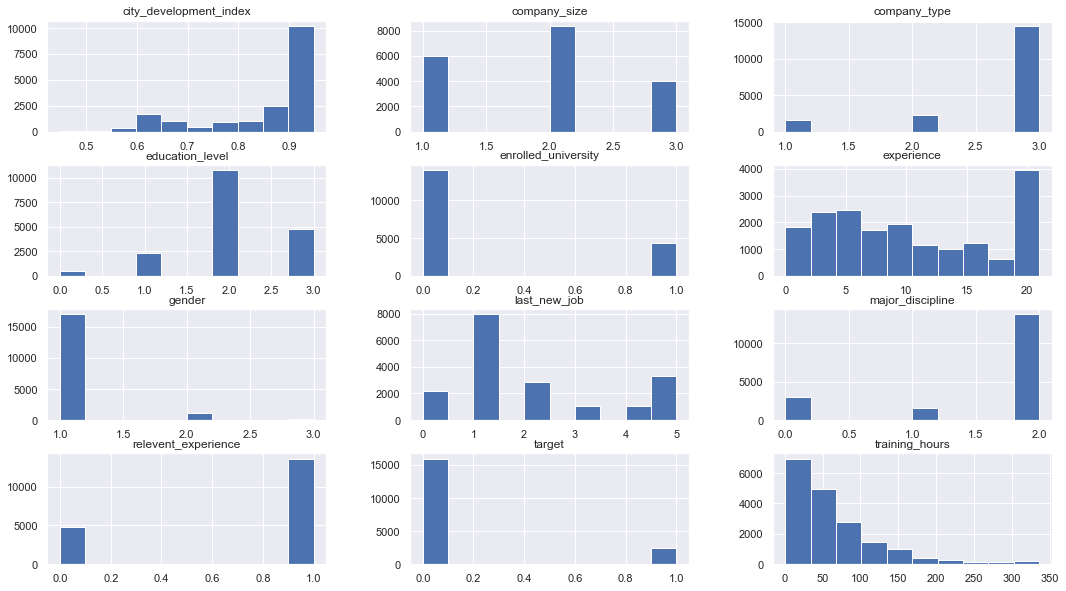

In [49]:
fig ,ax = plt.subplots(figsize=(18,10))
df.hist(ax=ax)
plt.show()

## 5.3 Variable vs Target (barplot)
<b>exclued variables: city_development_index, experience, training_hours, target</b>

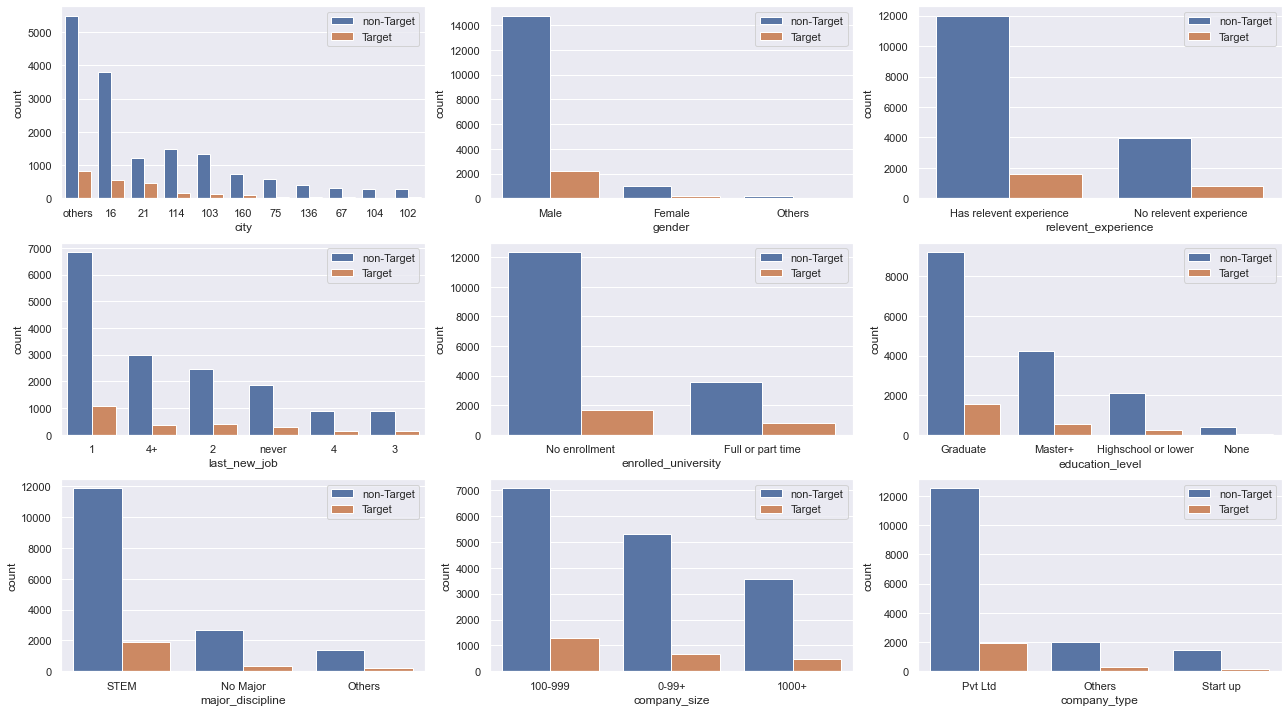

In [50]:
dic_col_value = {'city' : ['others', '16', '21', '114', '103', '160', '75', '136', '67', '104', '102'],
          'gender' : ['Male' , 'Female', 'Others'],
          'relevent_experience':  ['Has relevent experience', 'No relevent experience'],
          'last_new_job' : ['1', '4+', '2', 'never', '4', '3'],
          'enrolled_university': ['No enrollment', 'Full or part time'],
          'education_level': ['Graduate', 'Master+', 'Highschool or lower', 'None'],
          'major_discipline': ['STEM', 'No Major', 'Others'],
          'company_size': ['100-999', '0-99+', '1000+'],
          'company_type': ['Pvt Ltd', 'Others', 'Start up']}

plt.figure(figsize=(18,10))
for i, (key, value) in enumerate(dic_col_value.items(),1):
    plt.subplot(3, 3, i)
    ax = sns.countplot(data=df, x=key, hue='target',order=df[key].value_counts().index)
    ax.set_xticklabels(value)
    ax.set_xlabel(key)
    ax.set_ylabel('count')
    #ax.set_suptitle('Variable vs Target')
    ax.legend(['non-Target', 'Target'])

plt.tight_layout()


In [57]:
# create a function to build a table 
def var_target_df(data,col):
    dataframe = pd.crosstab(data[col],df['target'])
    dataframe['Target pct'] = dataframe[1]/dataframe.sum(axis=1)*100
    dataframe = round(dataframe,2)
    dataframe.columns.name=None
    dataframe = dataframe.rename(columns={0:'non-Target', 1:'Target'})
    dataframe.index.name = None
    dataframe['sum'] = dataframe.sum(axis=1)
    dataframe = dataframe.sort_values('sum',ascending=False)
    dataframe = dataframe.drop('sum',axis=1)
    return dataframe
    

In [58]:
# create func to make barplot
def barplot(data, col, labels):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="target", data=df, order = data[col].value_counts().index, ax=ax)
    ax.set_title('target vs %s'%col, fontsize=16, fontweight='bold')
    ax.set_xticklabels(labels)
    ax.set_xlabel(col,fontsize=14)
    ax.set_ylabel('count', fontsize=14)
    ax.legend(['non-Target', 'Target'])
    plt.show()


In [59]:
# create function to make histogram with min, max, 1st, 2nd(median), 3rd quantile.
def create_hist_withquantile(data,col,n):
    per50 = df[col].describe()['50%']
    per25 = df[col].describe()['25%']
    per75 = df[col].describe()['75%']
    min = df[col].describe()['min']
    max = df[col].describe()['max']
    cityidx = sns.displot(df,x=col,hue='target', multiple='stack', bins=n)
    cityidx.fig.set_figwidth(11)
    cityidx.fig.set_figheight(6)
    plt.axvline(per50,color='r')
    plt.axvline(per25,color='r',linestyle='--')
    plt.axvline(per75,color='r',linestyle='--')
    plt.axvline(min,color='r',linestyle='-.')
    plt.axvline(max,color='r',linestyle='-.')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()

## 5.4 Target vs Variable breakdown

### 5.4.1 target vs. city

In [60]:
var_target_df(df,'city')

,non-Target,Target,Target pct
others,5500,834,13.17
103,3795,563,12.92
21,1219,453,27.09
16,1500,154,9.31
114,1336,136,9.24
160,729,98,11.85
136,575,49,7.85
67,406,49,10.77
75,300,32,9.64
104,297,21,6.60


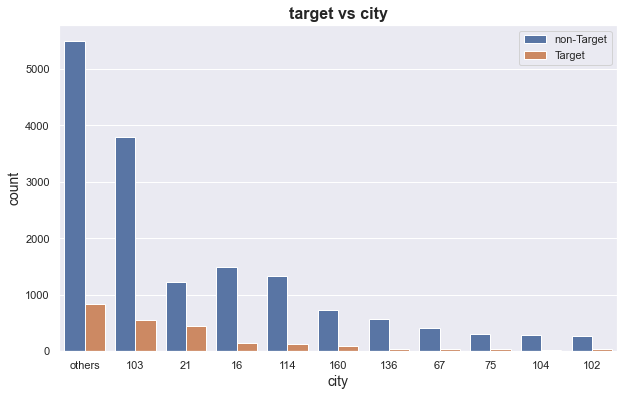

In [61]:
# plot table and barplot for city
barplot(df, 'city', df.city.value_counts().index)

In [62]:
# Top 3 city that has the highest ratio of target(class 1.0)
var_target_df(df,'city').nlargest(columns='Target pct', n=3)

,non-Target,Target,Target pct
21,1219,453,27.09
others,5500,834,13.17
103,3795,563,12.92


In [63]:
var_target_df(df,'city_development_index').nlargest(columns='Target', n=10)

,non-Target,Target,Target pct
0.920,4524,661,12.75
0.624,1219,453,27.09
0.910,1500,154,9.31
0.926,1336,136,9.24
0.698,554,101,15.42
0.897,575,49,7.85
0.855,406,49,10.77
0.939,496,48,8.82
0.887,227,44,16.24
0.754,226,38,14.39


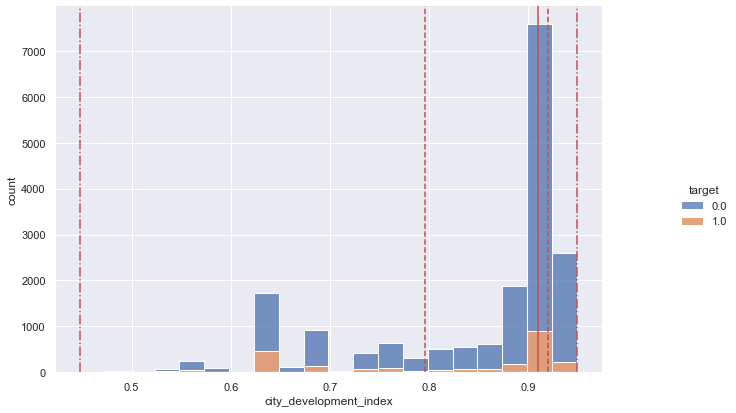

In [64]:
# plot table and histogram for city_development_index top 10
create_hist_withquantile(df, 'city_development_index', 20)

In [65]:
print(df[df.city_development_index == 0.920].city.value_counts())
print(df[df.city_development_index == 0.624].city.value_counts())

103    4358
160     827
Name: city, dtype: int64
21    1672
Name: city, dtype: int64


### 5.4.2 target vs experience 

In [66]:
# table for relevent_experience
var_target_df(df , 'relevent_experience').rename(index = {1: 'Has relevent experience' , 0: 'No relevent experience'})

,non-Target,Target,Target pct
Has relevent experience,12002,1594,11.72
No relevent experience,3932,831,17.45


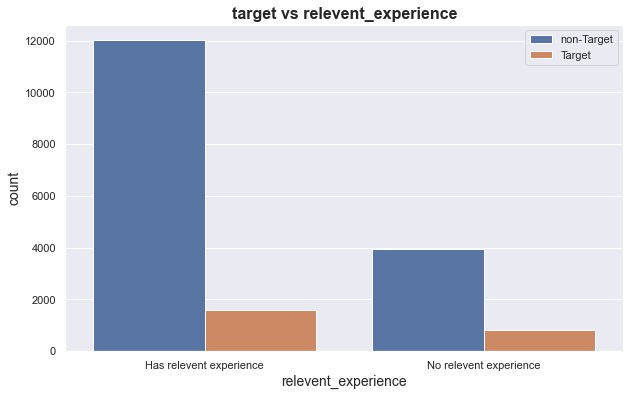

In [67]:
# bar plot for relevent_experience
barplot(df, 'relevent_experience', ['Has relevent experience', 'No relevent experience'])

In [68]:
# table for last_new_job
var_target_df(df, 'last_new_job').rename(index = {0:'never' , 5:'4+'})

,non-Target,Target,Target pct
1.0,6846,1088,13.71
4+,2978,361,10.81
2.0,2446,389,13.72
never,1876,310,14.18
4.0,891,147,14.16
3.0,897,130,12.66


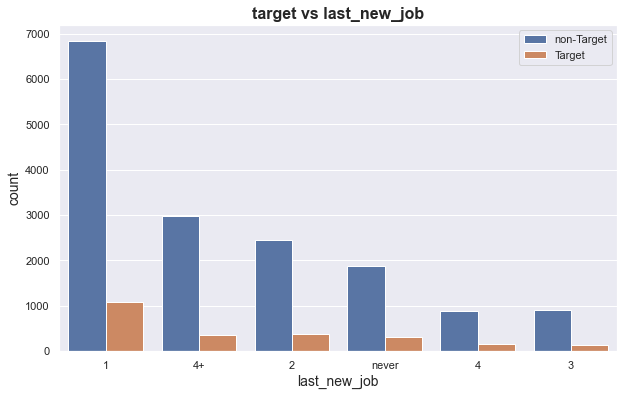

In [69]:
barplot(df, 'last_new_job', ['1', '4+', '2', 'never', '4', '3'])

In [70]:
# table for experience
df.groupby('target')['experience'].describe().rename(index = {0:'non-Target' , 1:'Target'})

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
non-Target,15934.0,10.872725,6.763342,0.0,5.0,10.0,17.0,21.0
Target,2425.0,9.164124,6.625679,0.0,4.0,7.0,14.0,21.0


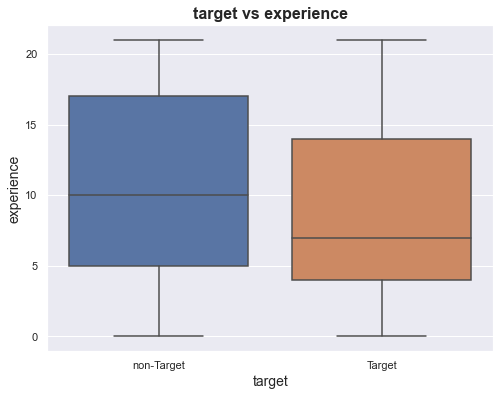

In [72]:
# Plot boxplot for experience vs target
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x='target', y='experience', data=df)
ax.set_title('target vs experience' , fontsize=16, fontweight='bold')
ax.set_xticklabels(['non-Target', 'Target'],rotation=0)
ax.set_xlabel('target',fontsize=14)
ax.set_ylabel('experience', fontsize=14)
plt.show()

### 5.4.3 target vs. employer

In [73]:
# table for for company_type
var_target_df(df, 'company_type').rename(index = {1:'Start up' , 2: 'Others', 3: 'Pvt Ltd'})

,non-Target,Target,Target pct
Pvt Ltd,12518,1956,13.51
Others,1966,299,13.20
Start up,1450,170,10.49


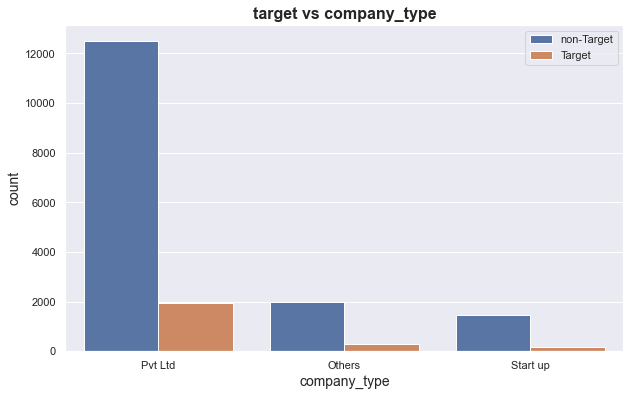

In [74]:
# bar plot for company_type
barplot(df, 'company_type', ['Pvt Ltd', 'Others', 'Start up'])

In [75]:
# table for company_size
var_target_df(df, 'company_size').rename(index = {1:'0-99' , 2: '100-999', 3: '1000+'})

,non-Target,Target,Target pct
100-999,7078,1293,15.45
0-99,5296,658,11.05
1000+,3560,474,11.75


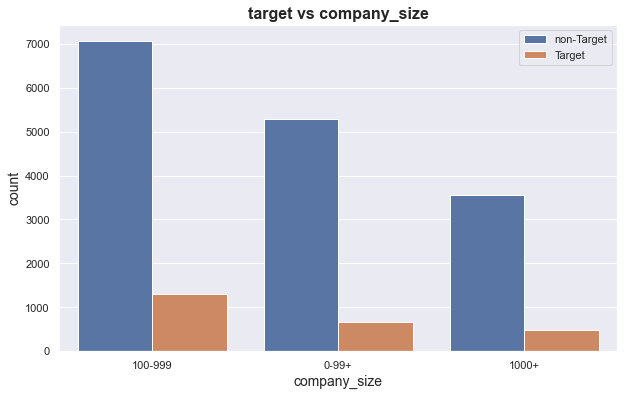

In [76]:
# bar plot for company_size
barplot(df, 'company_size', ['100-999', '0-99+', '1000+'])

### 5.4.4 target vs. education

In [77]:
# table for major_discipline
var_target_df(df, 'major_discipline').rename(index = {0:'No Major' , 1:'Others', 2:'STEM'})

,non-Target,Target,Target pct
STEM,11880,1884,13.69
No Major,2671,347,11.50
Others,1383,194,12.30


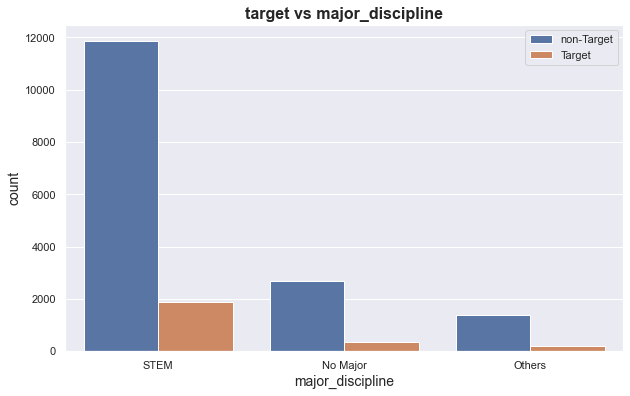

In [78]:
# bar plot for major_discipline
barplot(df, 'major_discipline', ['STEM', 'No Major', 'Others'])

In [79]:
# table for education_level
var_target_df(df, 'education_level').rename(index = {0: 'None', 1:'Highschool or lower' , 2: 'Graduate', 3: 'Master or higher'})

,non-Target,Target,Target pct
Graduate,9237,1532,14.23
Master or higher,4212,566,11.85
Highschool or lower,2089,266,11.30
None,396,61,13.35


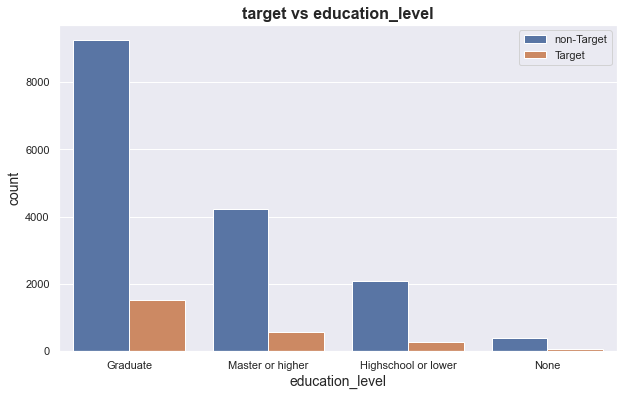

In [80]:
# bar plot for education_level
barplot(df, 'education_level', ['Graduate', 'Master or higher', 'Highschool or lower', 'None'])

In [81]:
# table for univeristy enrollment
var_target_df(df, 'enrolled_university').rename(index = {1: 'Full or part time' , 0: 'No enrollment'})

,non-Target,Target,Target pct
No enrollment,12357,1644,11.74
Full or part time,3577,781,17.92


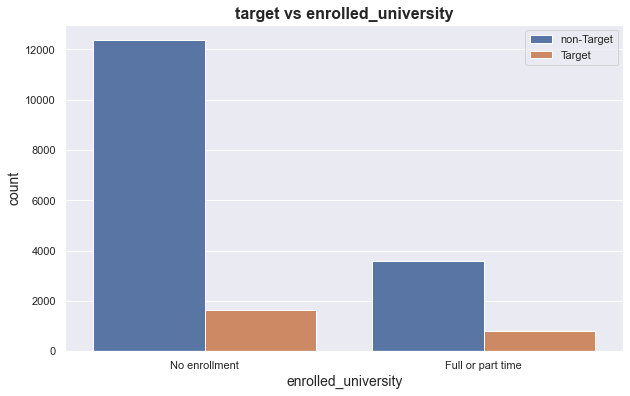

In [82]:
# bar plot for univeristy enrollment
barplot(df, 'enrolled_university', ['No enrollment', 'Full or part time'])

### 5.4.5 target vs. gender

In [83]:
# table for gender
var_target_df(df, 'gender').rename(index = {1:'Male' , 2:'Female', 3:'Others'})

,non-Target,Target,Target pct
Male,14765,2217,13.05
Female,1009,179,15.07
Others,160,29,15.34


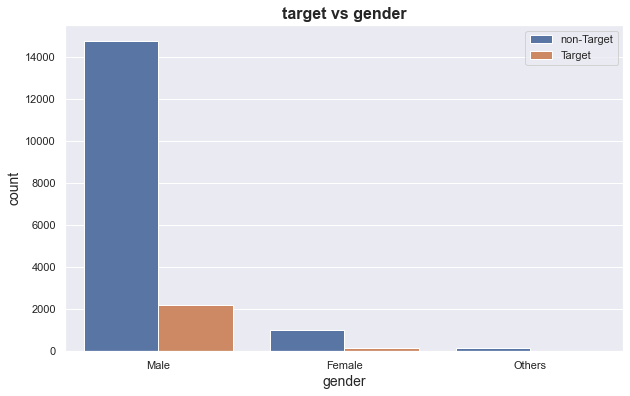

In [84]:
# bar plot for gender 
barplot(df, 'gender', ['Male', 'Female', 'Others'])

### 5.4.6 target vs. training hours

In [85]:
# table for training_hours
df.groupby('target')['training_hours'].describe().rename(index = {0:'non-Target' , 1:'Target'})

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
non-Target,15934.0,66.011485,60.908040,1.0,23.0,47.0,89.0,336.0
Target,2425.0,65.160000,60.743027,1.0,23.0,47.0,87.0,336.0


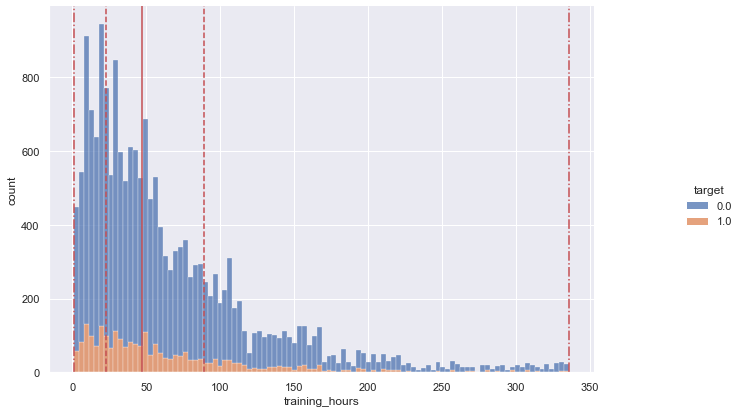

In [86]:
# histogram for training_hours
create_hist_withquantile(df,'training_hours',100)

# 5 Machine Learning

## 5.1 Data Preprocessing and Feature Selection

In [87]:
# encode the last object column 'city' via dummy encoding
cat_col= data_info(df)[data_info(df).data_type=='object'].column.tolist()
df = pd.get_dummies(df,columns=cat_col)
df.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_103,city_104,city_114,city_136,city_16,city_160,city_21,city_67,city_75,city_others
0,0.689,1.0,1.0,0.0,2.0,2.0,3.0,2.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.923,1.0,1.0,0.0,2.0,2.0,14.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.910,1.0,1.0,0.0,2.0,2.0,6.0,1.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,0.666,1.0,1.0,0.0,2.0,2.0,14.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,0.887,1.0,0.0,0.0,3.0,2.0,8.0,2.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [88]:
df.shape

(18359, 23)

In [89]:
data_info(df)

,column,counts,unique_value_pct,nan_pct,data_type
10,training_hours,241,1.31,0.0,float64
0,city_development_index,93,0.51,0.0,float64
6,experience,22,0.12,0.0,float64
9,last_new_job,6,0.03,0.0,float64
4,education_level,4,0.02,0.0,float64
5,major_discipline,3,0.02,0.0,float64
7,company_size,3,0.02,0.0,float64
8,company_type,3,0.02,0.0,float64
1,gender,3,0.02,0.0,float64
16,city_136,2,0.01,0.0,uint8


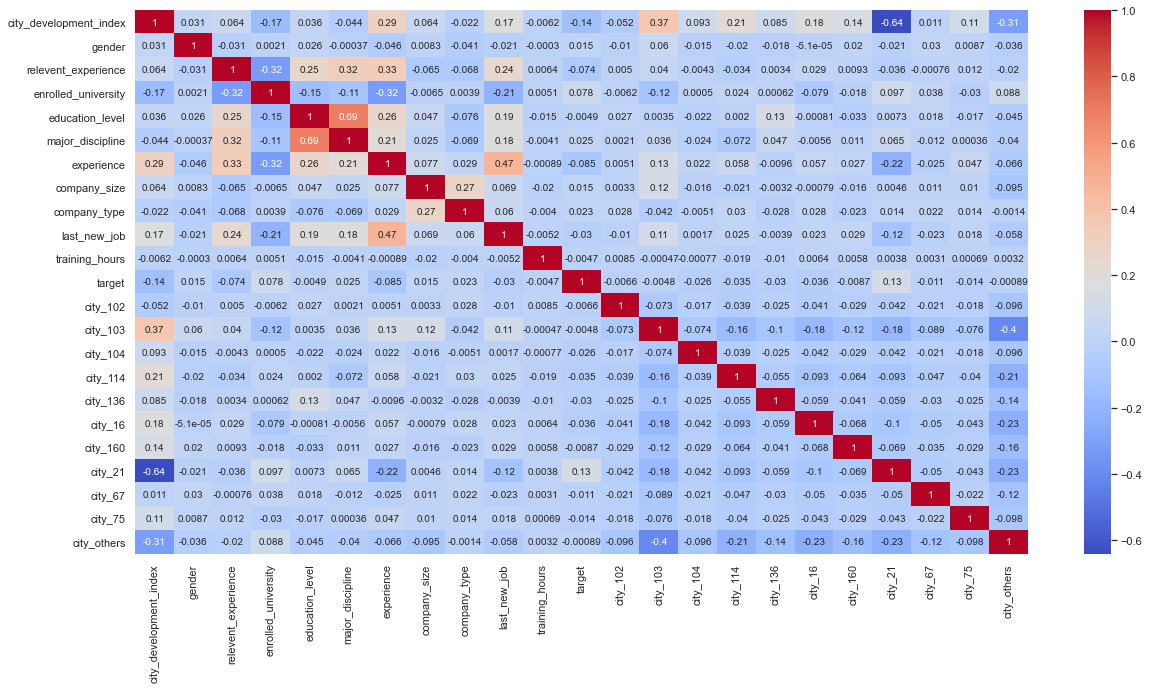

In [90]:
# check correlation between each variable
_= plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(),cmap='coolwarm', annot=True) 
plt.show()

In [91]:
X = df.drop('target',axis=1)
y = df['target'].ravel()

In [92]:
X.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,...,city_103,city_104,city_114,city_136,city_16,city_160,city_21,city_67,city_75,city_others
0,0.689,1.0,1.0,0.0,2.0,2.0,3.0,2.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.923,1.0,1.0,0.0,2.0,2.0,14.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.910,1.0,1.0,0.0,2.0,2.0,6.0,1.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0
3,0.666,1.0,1.0,0.0,2.0,2.0,14.0,1.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,0.887,1.0,0.0,0.0,3.0,2.0,8.0,2.0,3.0,2.0,...,0,0,0,0,0,0,0,0,0,1


In [93]:
# # X_scaled = StandardScaler().fit_transform(X)

# # X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)


# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() 
# X_scaled = scaler.fit_transform(X)
# X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [94]:
X_new = X.to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X_new, y, test_size=0.30, stratify=y, random_state=43)

In [95]:
# check target count in full, train, test dataset 
target_test_set = np.unique(y_test,return_counts=True)[1]
target_train_set = np.unique(y_train,return_counts=True)[1]
target_full_set= np.unique(df.target,return_counts=True)[1]

In [96]:
df_target = pd.DataFrame([target_full_set,target_train_set,target_test_set ], 
                         index=['Full Dataset', 'Training set', 'Testing set'], 
                         columns=['non-Target count', 'Target count'])

df_target['Target %'] = round(df_target['Target count']/df_target.sum(axis=1)*100,3)
df_target

,non-Target count,Target count,Target %
Full Dataset,15934,2425,13.209
Training set,11154,1697,13.205
Testing set,4780,728,13.217


<font color='red'>Make sure stratified training and testing sets have roughly the same target enrollee percentage</font>

We can see in our training set, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happenswe will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.¥

## 5.2 Modle Selection and Introduction

### 5.2.1 Build Models with Default settings

In [97]:
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']

models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
model_dict = dict(zip(index,models))

### 5.2.2 Model Evaluation using metrics: recall, precision, f1 score, roc_auc

In [98]:
# create a function to train model with n fold cv and return the result
def model_eval(model_name, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X_train,
                                          y=y_train,
                                          cv=kfold,
                                          scoring=scoring)
    
    res = pd.DataFrame(model_res).round(3)
    return res

In [99]:
# create a function to return the test result for all models
def allmodel_perform(n, model_ev):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []
    
    # Loop inside the model_dict and average the test_score by calling function model_eval()
    # (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_ev(model, n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dict.keys())).round(3)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [100]:
model_res = allmodel_perform(5, model_eval)
model_res

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.097,0.009,0.868,0.000,0.000,0.000,0.637
1,GNB,0.004,0.010,0.754,0.233,0.373,0.286,0.629
2,KNN,0.011,0.118,0.853,0.204,0.038,0.064,0.535
3,SVC,7.345,0.427,0.868,0.000,0.000,0.000,0.499
4,DT,0.037,0.008,0.767,0.178,0.210,0.193,0.531
5,RF,0.845,0.125,0.858,0.278,0.047,0.080,0.603
6,GB,0.918,0.017,0.868,0.434,0.006,0.012,0.642
7,XGB,0.666,0.017,0.861,0.320,0.049,0.085,0.611
8,LightGB,0.835,0.019,0.867,0.358,0.019,0.036,0.626


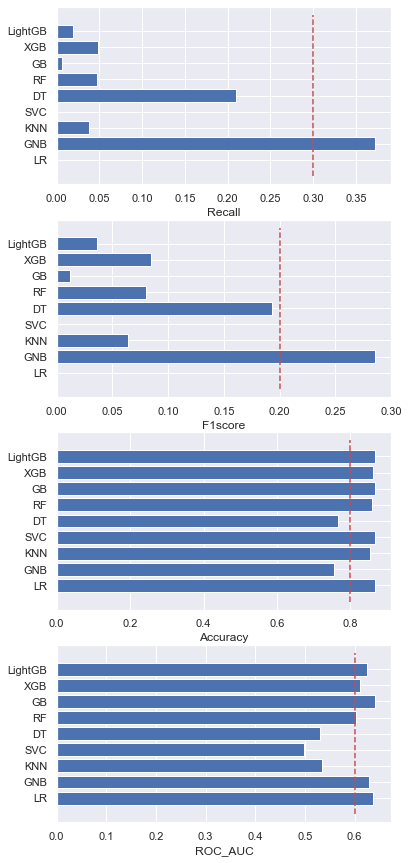

In [101]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,15))

axs[0].barh('model', 'test_recall', data=model_res)
axs[1].barh('model', 'test_f1_score', data=model_res)
axs[2].barh('model', 'test_accuracy', data=model_res)
axs[3].barh('model', 'test_roc_auc',data=model_res)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.3,0.3],[-1,9],'r--')
axs[1].plot([0.2,0.2],[-1,9],'r--')
axs[2].plot([0.8,0.8],[-1,9],'r--')
axs[3].plot([0.6,0.6],[-1,9],'r--')
plt.show()

In [102]:
# def trainmodel_cv(model_name, X, y, n):
    
#     kfold = KFold(n_splits=n)
#     model = model_name

#     model_res = model_selection.cross_validate(
#                                           estimator=model,
#                                           X=X,
#                                           y=y,
#                                           cv=kfold)
#     model.fit(X, y)
#     #model.fit(X_train, y_train)
#     return model

### 5.2.3 Model evaluation using metrics: lift

In [103]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold)
    
    return model

In [104]:
# train model with n cross validation 
# then plot lift curve and 'predicted probability' vs 'label of test data' histogram based on model prediction 
# then return model score on test data 
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    #predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.0,0.0,0.0,0.644,620.0,1140.0


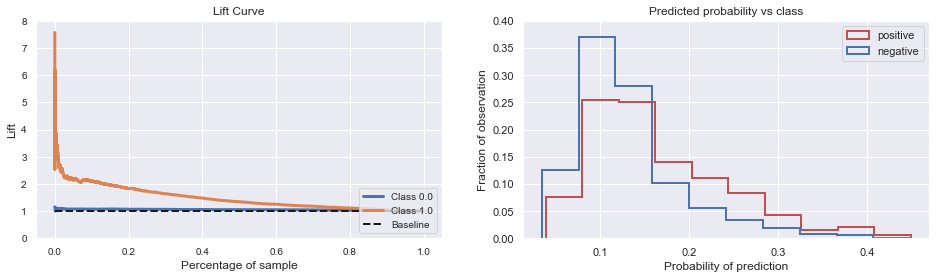

In [105]:
liftcurve_probahisto_score(trainmodel_cv,LogisticRegression(), 'LogisticRegression', 5, X_train, y_train, 8, 0.4)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.0,0.0,0.0,0.629,262.0,483.0


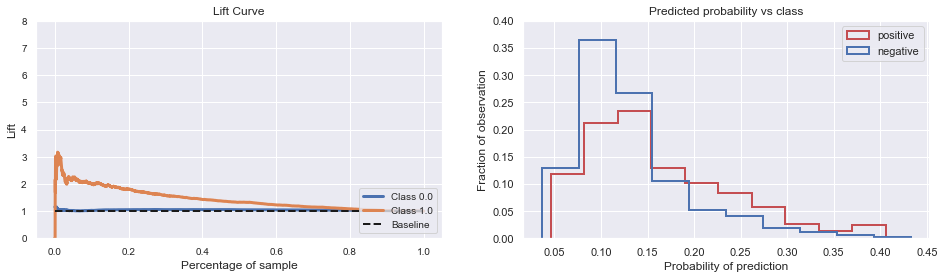

In [106]:
liftcurve_probahisto_score(trainmodel_cv,LogisticRegression(), 'LogisticRegression', 5, X_test, y_test, 8, 0.4)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.234,0.346,0.279,0.633,599.0,1120.0


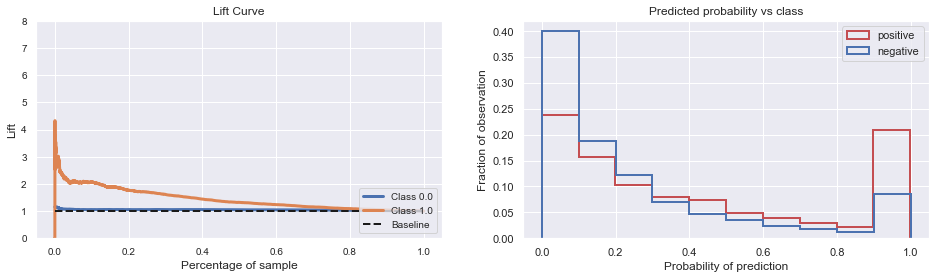

In [107]:
liftcurve_probahisto_score(trainmodel_cv, GaussianNB(), 'GaussianNB', 5, X_train, y_train, 8, 0.42)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.23,0.337,0.274,0.608,251.0,458.0


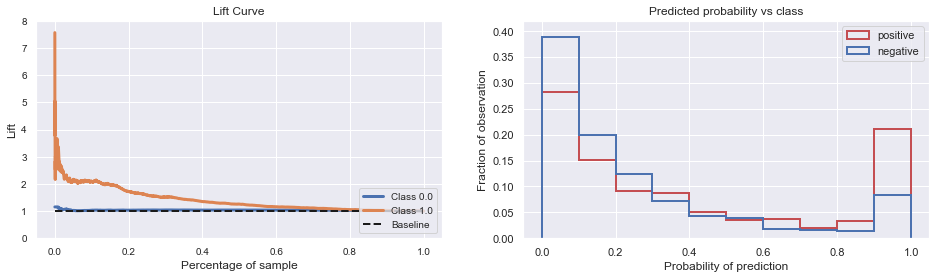

In [108]:
liftcurve_probahisto_score(trainmodel_cv, GaussianNB(), 'GaussianNB', 5, X_test, y_test, 8, 0.42)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.561,0.111,0.185,0.784,834.0,1545.0


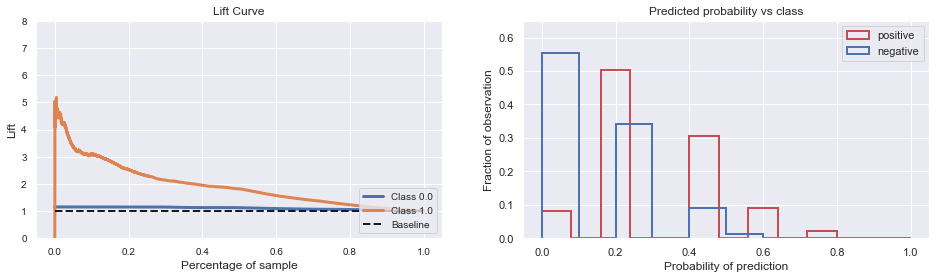

In [109]:
liftcurve_probahisto_score(trainmodel_cv, KNeighborsClassifier(), 'KNN', 5, X_train, y_train, 8, 0.65)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.21,0.041,0.069,0.55,189.0,413.0


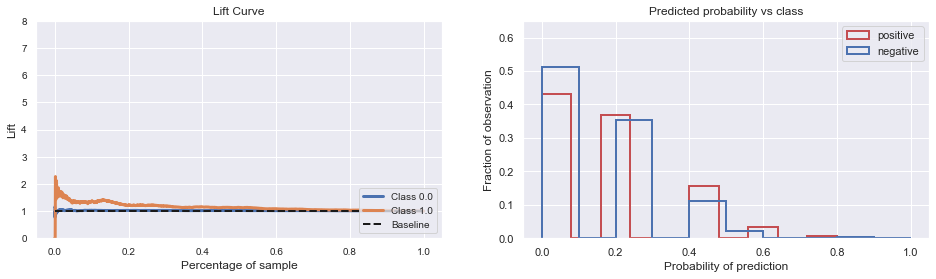

In [110]:
liftcurve_probahisto_score(trainmodel_cv, KNeighborsClassifier(), 'KNN', 5, X_test, y_test, 8, 0.65)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.819,0.843,0.831,0.911,1468.0,1683.0


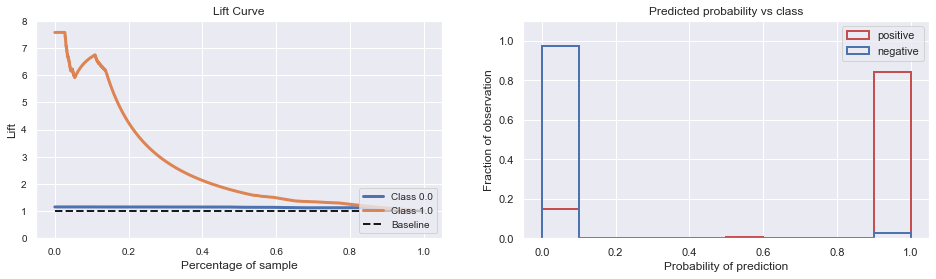

In [111]:
liftcurve_probahisto_score(trainmodel_cv, DecisionTreeClassifier(random_state=43), 'DT', 5, X_train, y_train, 8, 1.1)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.179,0.22,0.197,0.533,186.0,391.0


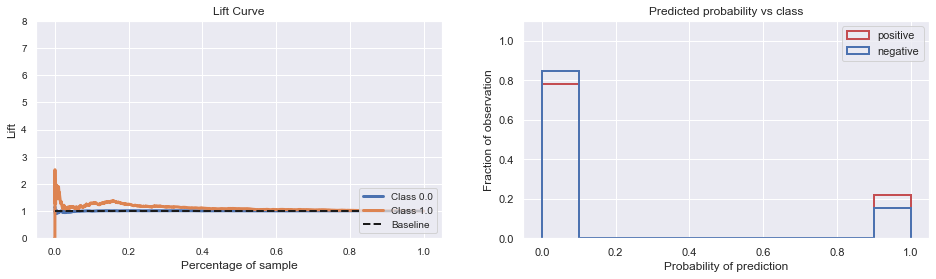

In [112]:
liftcurve_probahisto_score(trainmodel_cv, DecisionTreeClassifier(random_state=43), 'DT', 5, X_test, y_test, 8, 1.1)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.968,0.81,0.882,0.96,1522.0,1646.0


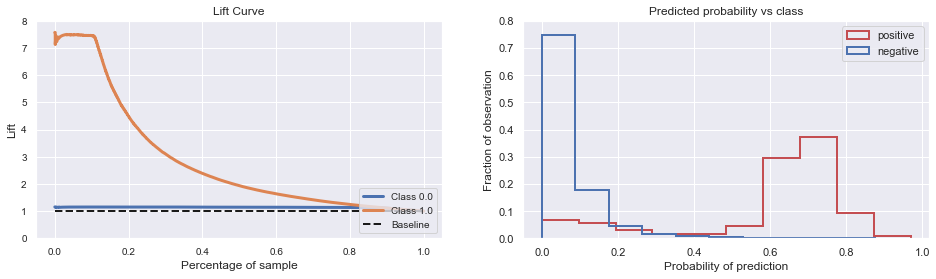

In [113]:
liftcurve_probahisto_score(trainmodel_cv, RandomForestClassifier(random_state=43), 'RF', 5, X_train, y_train, 8, 0.8)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.27,0.051,0.086,0.594,211.0,456.0


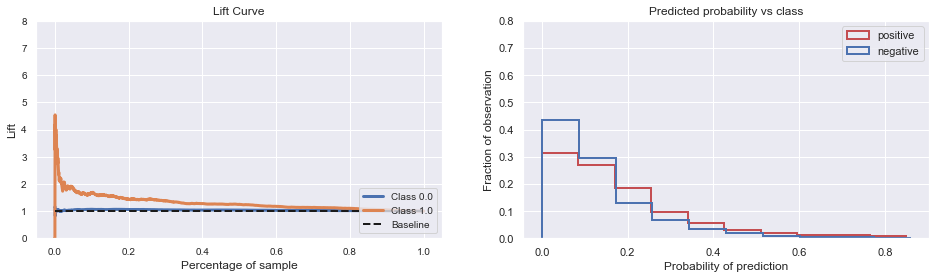

In [114]:
liftcurve_probahisto_score(trainmodel_cv, RandomForestClassifier(random_state=43), 'RF', 5, X_test, y_test, 8, 0.8)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.886,0.018,0.036,0.705,720.0,1259.0


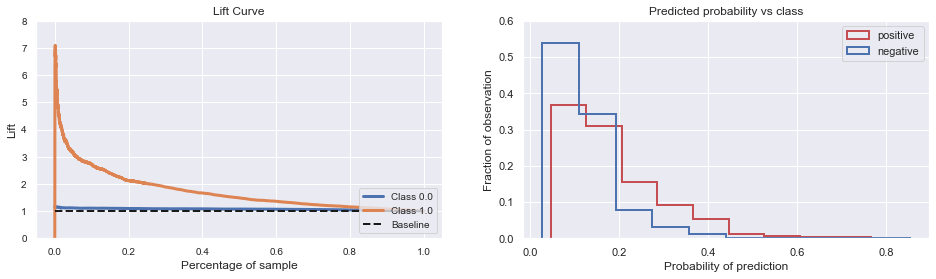

In [115]:
liftcurve_probahisto_score(trainmodel_cv,GradientBoostingClassifier(random_state=43), 'GB', 5, X_train, y_train, 8, 0.6)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.286,0.003,0.005,0.645,259.0,493.0


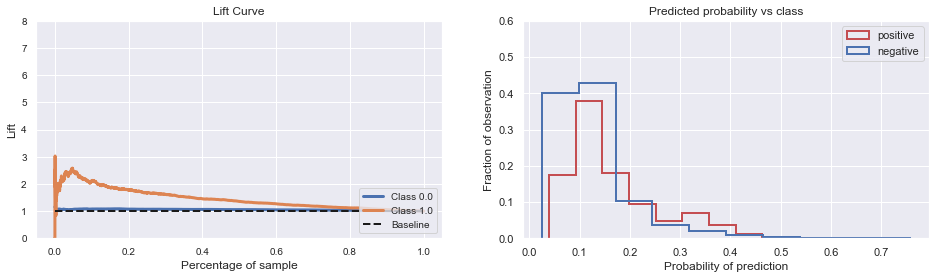

In [116]:
liftcurve_probahisto_score(trainmodel_cv,GradientBoostingClassifier(random_state=43), 'GB', 5, X_test, y_test, 8, 0.6)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.886,0.265,0.408,0.881,1247.0,1546.0


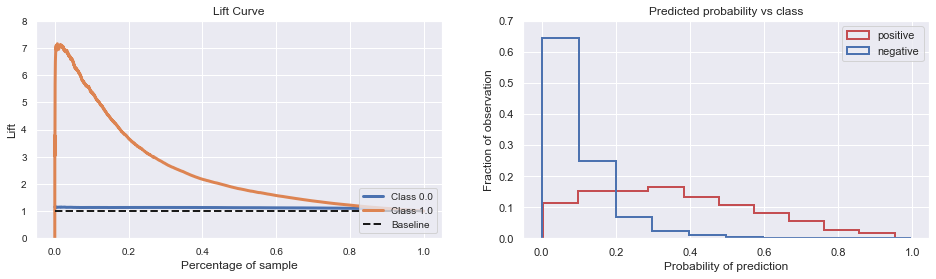

In [117]:
liftcurve_probahisto_score(trainmodel_cv, XGBClassifier(random_state=43), 'XGB', 5, X_train, y_train, 8, 0.7)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.22,0.037,0.063,0.599,225.0,456.0


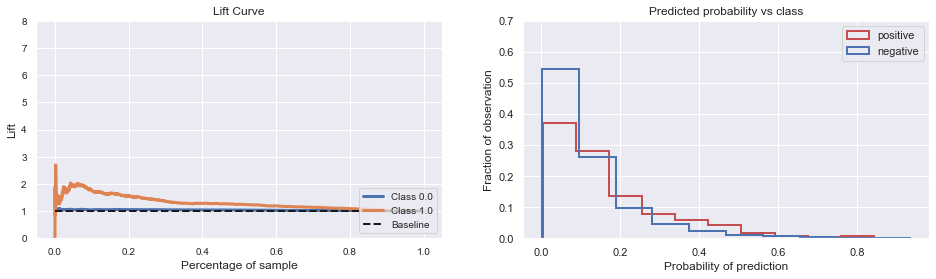

In [118]:
liftcurve_probahisto_score(trainmodel_cv, XGBClassifier(random_state=43), 'XGB', 5, X_test, y_test, 8, 0.7)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.86,0.058,0.108,0.838,1057.0,1513.0


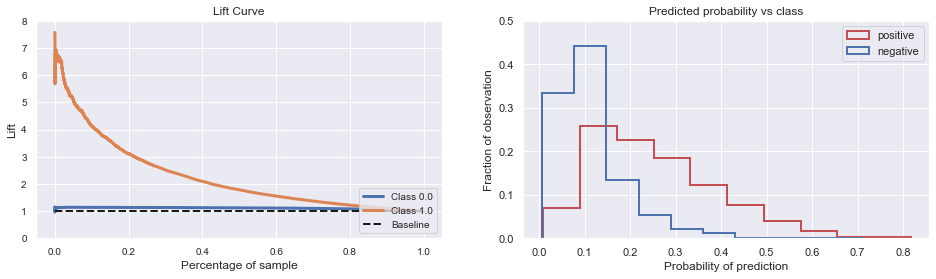

In [119]:
liftcurve_probahisto_score(trainmodel_cv, lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB', 5, X_train, y_train, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.333,0.016,0.031,0.618,237.0,473.0


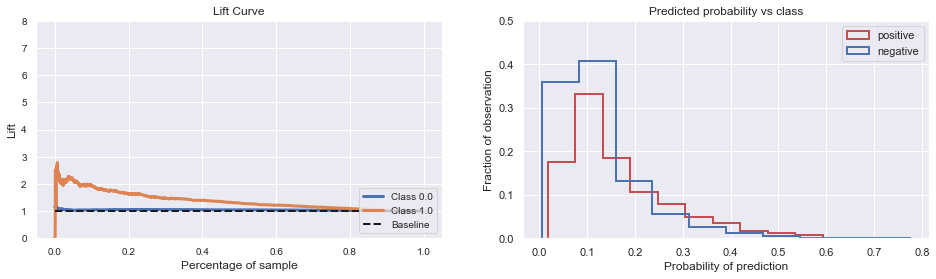

In [120]:
liftcurve_probahisto_score(trainmodel_cv, lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB', 5, X_test, y_test, 8, 0.5)

In [121]:
#liftcurve_probahisto_score(trainmodel_cv, SVC(probability=True, random_state=43), 'SVC', 5, X_train, y_train, 8, 1.0)

In [122]:
#liftcurve_probahisto_score(trainmodel_cv, SVC(probability=True, random_state=43), 'SVC', 5, X_test, y_test, 8, 1.0)

### 5.2.4 Oversampling (SMOTE)

In [123]:
# create function to train models with n fold cross validation and oversample data only on the train fold in each cross validation 
# and return test result of score precision, recall, f1score, auc, roc_auc
def model_eval_os(model_name, n):
    
    precisions = []
    recalls = []
    f1scores = []
    aucs = []
    roc_aucs=[]
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model = model_name
        
        model.fit(X_train_oversampled, y_train_oversampled)
        
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:,1]
        
       
        recalls.append(recall_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        precisions.append(precision_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        f1scores.append(f1_score(y_test_fold, y_pred, pos_label=1,average='binary'))
        roc_aucs.append(roc_auc_score(y_test_fold, y_pred_proba))
        aucs.append(model.score(X_test_fold, y_test_fold))
     
    
    res = pd.DataFrame([precisions,recalls,f1scores,aucs,roc_aucs]).T
    res.columns = ['test_precison', 'test_recall', 'test_f1score', 'test_accuracy', 'test_roc_auc']
    
    return res

### 5.2.5 Model Evaluation after oversamping using metrics: recall, precision, f1 score, roc_auc

In [124]:
# call function allmodel_perform() to get the test for all models 
# using model_eval_os() function to get result after oversampling dataset

model_res_os = allmodel_perform(5, model_eval_os)

In [125]:
model_res_os.sort_values('test_recall', ascending=False)

,model,test_precison,test_recall,test_f1score,test_accuracy,test_roc_auc
1,GNB,0.158,0.717,0.259,0.459,0.618
3,SVC,0.155,0.660,0.251,0.480,0.593
0,LR,0.195,0.529,0.285,0.649,0.636
2,KNN,0.145,0.464,0.221,0.570,0.533
4,DT,0.179,0.216,0.196,0.766,0.534
5,RF,0.267,0.062,0.101,0.854,0.601
7,XGB,0.279,0.042,0.073,0.859,0.614
8,LightGB,0.341,0.027,0.050,0.865,0.626
6,GB,0.381,0.024,0.045,0.866,0.635


### 5.2.6 Model Evaluation after oversamping using metrics: lift

In [126]:
# create a function to train final model on oversampled data with n fold cross validation and return final model.
def trainmodel_os_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train,y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        
        os = SMOTE(random_state=43)
        X_train_oversampled, y_train_oversampled = os.fit_sample(X_train_fold, y_train_fold)
        model.fit(X_train_oversampled, y_train_oversampled)
    
    return model

There's 728 positive datapoints(label=1) in y_test which contains 5508 datapoints.
<br>If we use LogisticRegression we can capture 264, 469 <b>label1</b> among the top 20%, top50% of the predicted result,
<br>meaning we can capture 36.3%, 64.4% of <b>label1</b> from the top20%,  top50% predicted result. (264/728=0.363)
<br>While using GaussianNB we can only capture 250, 449 label1 among the top 20%, top50% of the predicted result.
<br>meaning we can capture 34.3%,  61.7% of <b>label1</b> from the top20%, top50% predicted result.
<br>* Question 1: Therefore we should choose LogisticRegression as the final model?
<br>* Question 2: As my dataset contains both continuous variables and discrete variables, so I am no very sure if I can use GaussianNB classifier in this case


,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.199,0.545,0.291,0.642,615.0,1130.0


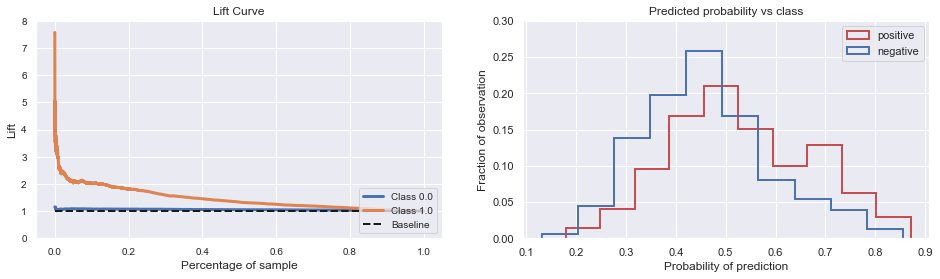

In [127]:
# get liftcurve, probahisto and scores on X_train, y_train for model LR

liftcurve_probahisto_score(trainmodel_os_cv, LogisticRegression(), 'LogisticRegression', 5, X_train, y_train, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LogisticRegression,0.192,0.521,0.281,0.623,253.0,480.0


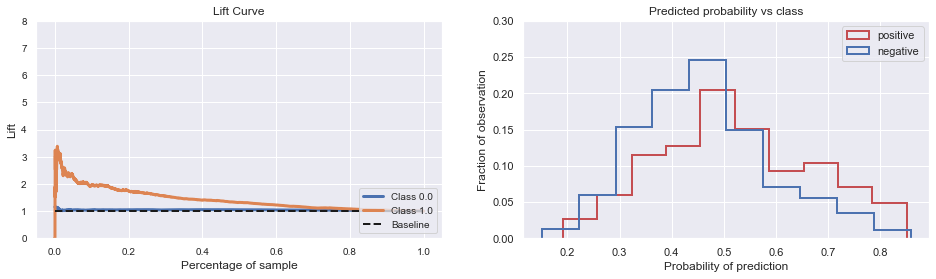

In [128]:
# get liftcurve, probahisto and scores on X_test, y_test for model LR
liftcurve_probahisto_score(trainmodel_os_cv, LogisticRegression(), 'LogisticRegression', 5, X_test, y_test, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.158,0.703,0.258,0.619,590.0,1074.0


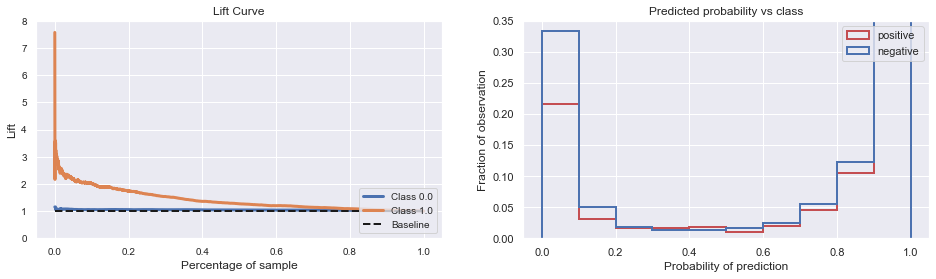

In [129]:
# get liftcurve, probahisto and scores on X_train, y_train for model GaussianNB
liftcurve_probahisto_score(trainmodel_os_cv, GaussianNB(), 'GaussianNB',  5, X_train, y_train, 8, 0.35)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GaussianNB,0.151,0.674,0.246,0.598,251.0,441.0


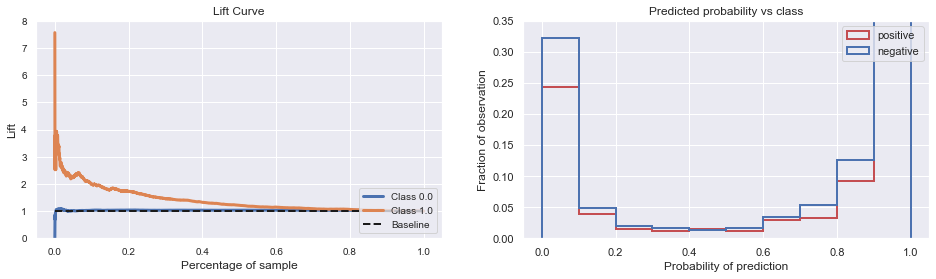

In [130]:
# get liftcurve, probahisto and scores on X_test, y_test for model GaussianNB
liftcurve_probahisto_score(trainmodel_os_cv, GaussianNB(), 'GaussianNB', 5, X_test, y_test, 8, 0.35)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.289,0.885,0.436,0.89,1313.0,1544.0


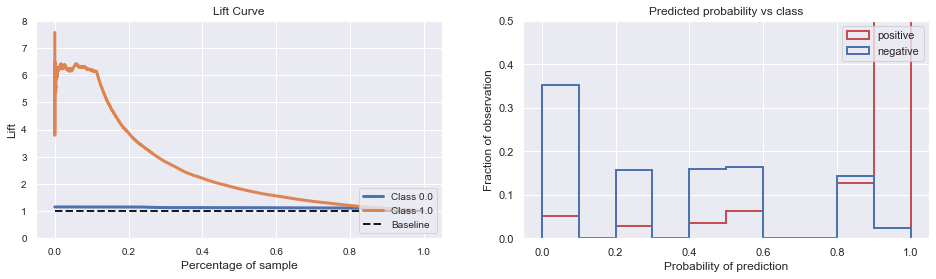

In [131]:
liftcurve_probahisto_score(trainmodel_os_cv, KNeighborsClassifier(), 'KNN',  5, X_train, y_train, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
KNN,0.144,0.455,0.218,0.541,182.0,391.0


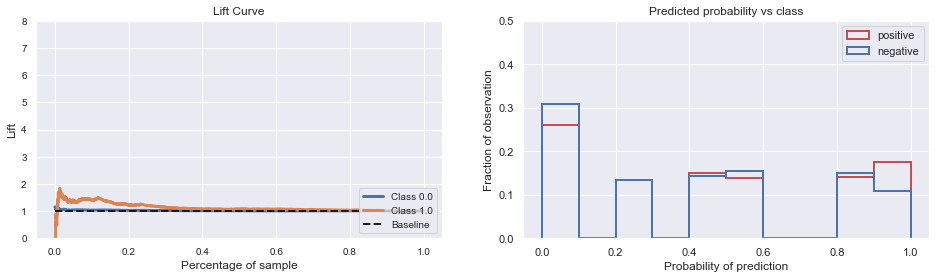

In [132]:
liftcurve_probahisto_score(trainmodel_os_cv, KNeighborsClassifier(), 'KNN',  5, X_test, y_test, 8, 0.5)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.816,0.834,0.825,0.907,1431.0,1626.0


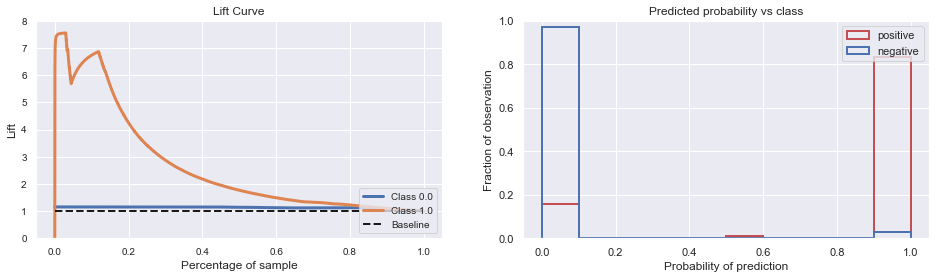

In [133]:
liftcurve_probahisto_score(trainmodel_os_cv, DecisionTreeClassifier(random_state=43), 'DT', 5,  X_train, y_train, 8, 1.0)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
DT,0.162,0.195,0.177,0.52,171.0,387.0


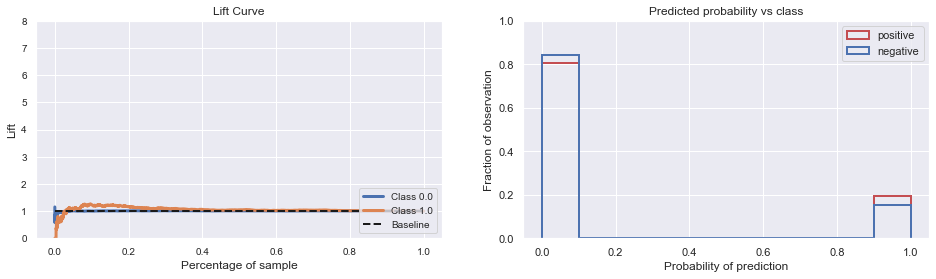

In [134]:
liftcurve_probahisto_score(trainmodel_os_cv, DecisionTreeClassifier(random_state=43), 'DT',  5, X_test, y_test, 8, 1.0)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.958,0.813,0.879,0.957,1519.0,1633.0


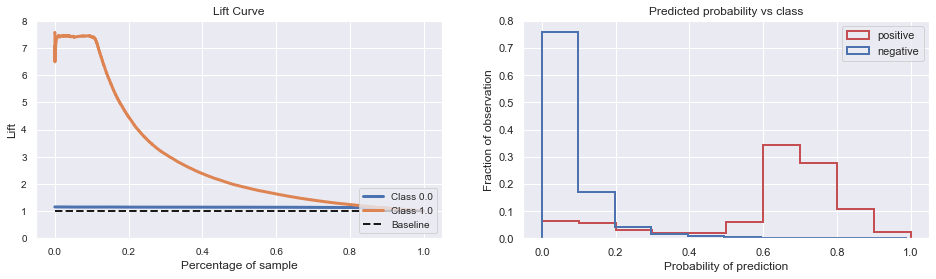

In [135]:
liftcurve_probahisto_score(trainmodel_os_cv, RandomForestClassifier(random_state=43), 'RF',  5, X_train, y_train, 8, 0.8)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
RF,0.235,0.06,0.096,0.592,202.0,451.0


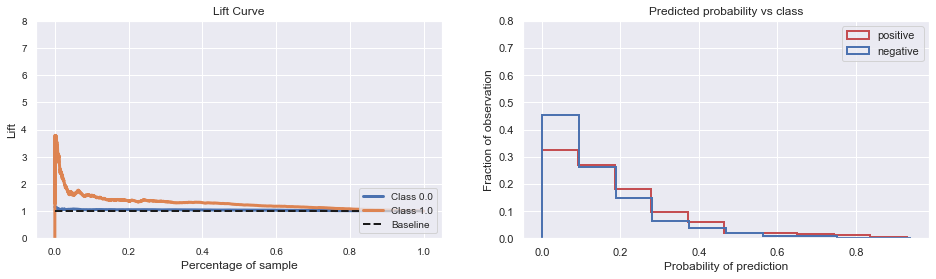

In [136]:
liftcurve_probahisto_score(trainmodel_os_cv, RandomForestClassifier(random_state=43), 'RF',  5, X_test, y_test, 8, 0.8)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.411,0.03,0.056,0.666,647.0,1183.0


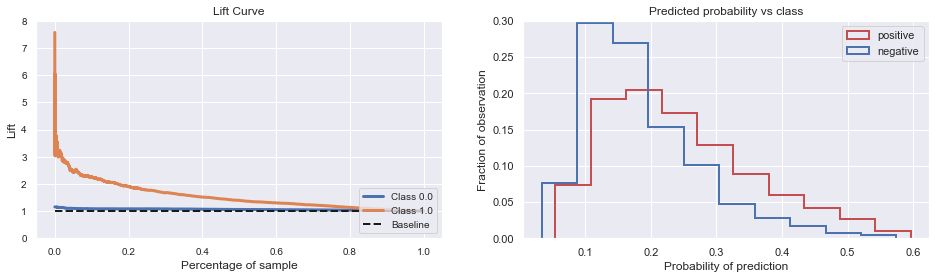

In [137]:
liftcurve_probahisto_score(trainmodel_os_cv, GradientBoostingClassifier(random_state=43), 'GB',  5, X_train, y_train, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
GB,0.381,0.033,0.061,0.633,260.0,475.0


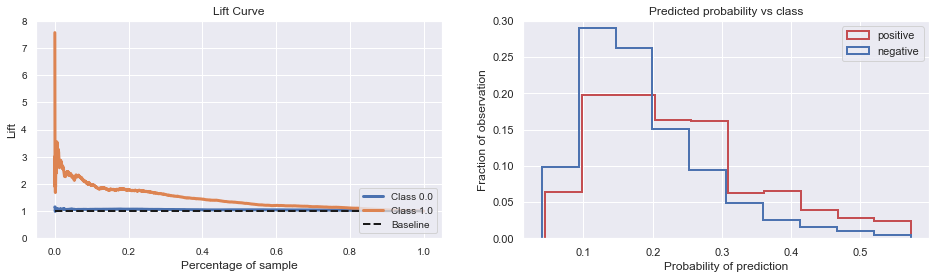

In [138]:
liftcurve_probahisto_score(trainmodel_os_cv, GradientBoostingClassifier(random_state=43), 'GB',  5, X_test, y_test, 8, 0.3)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.865,0.227,0.359,0.871,1205.0,1542.0


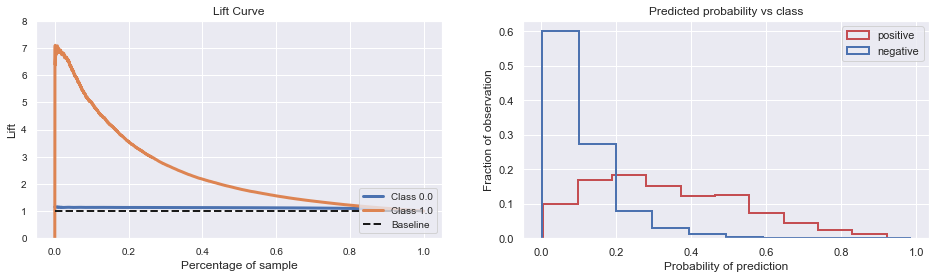

In [139]:
liftcurve_probahisto_score(trainmodel_os_cv, XGBClassifier(random_state=43), 'XGB',  5, X_train, y_train, 8, 0.63)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
XGB,0.257,0.038,0.067,0.6,215.0,450.0


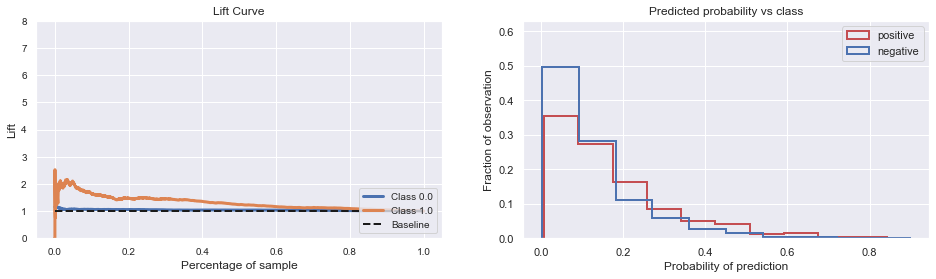

In [140]:
liftcurve_probahisto_score(trainmodel_os_cv, XGBClassifier(random_state=43), 'XGB',  5, X_test, y_test, 8, 0.63)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.762,0.077,0.14,0.808,972.0,1459.0


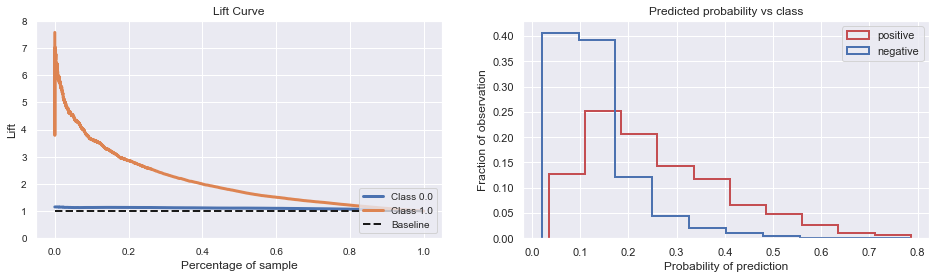

In [141]:
liftcurve_probahisto_score(trainmodel_os_cv, lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_train, y_train, 8, 0.43)

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
LightGB,0.309,0.029,0.053,0.628,236.0,484.0


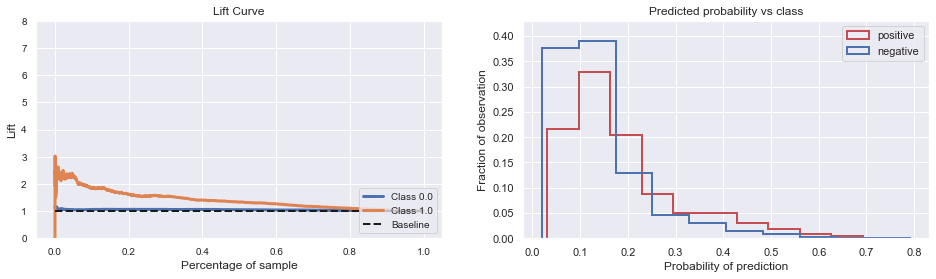

In [142]:
liftcurve_probahisto_score(trainmodel_os_cv, lgb.LGBMClassifier(objective='binary',random_state=43), 'LightGB',  5, X_test, y_test, 8, 0.43)

In [143]:
#liftcurve_probahisto_score(trainmodel_os_cv, SVC(probability=True, random_state=43), 'SVC',  5,  X_train, y_train, 6, 0.3)

In [144]:
#iftcurve_probahisto_score(trainmodel_os_cv, SVC(probability=True, random_state=43), 'SVC',  5,  X_test, y_test, 6, 0.3)

In [145]:
## Check feature importance for model GaussianNB and LogisticRegression

<BarContainer object of 22 artists>

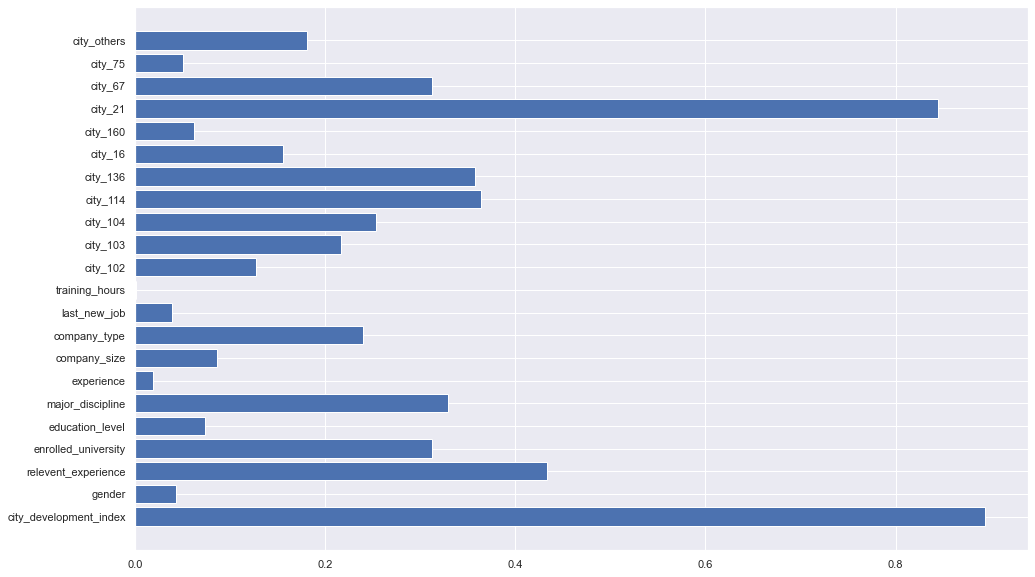

In [146]:
# check feature importance for LogisticRegression
model = trainmodel_os_cv(LogisticRegression(), 5)
len(model.coef_[0])

fig,ax = plt.subplots(figsize=(16,10))
    
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(model.coef_[0]))

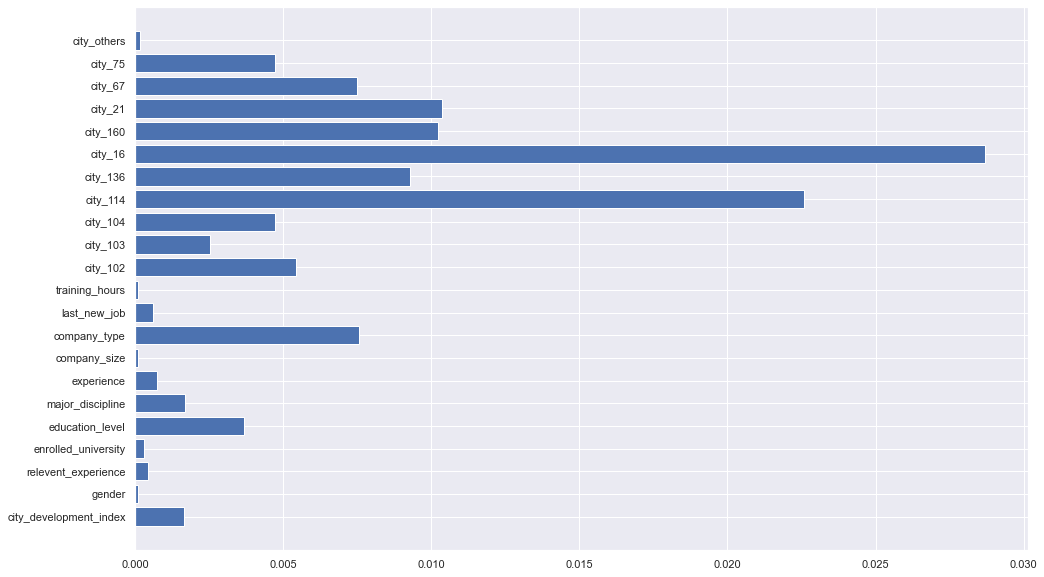

In [147]:
# check feature importance for GaussianNB
from sklearn.inspection import permutation_importance
model = trainmodel_os_cv(GaussianNB(),  5)

imps = permutation_importance(model, X_train, y_train)
fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), abs(imps.importances_mean))
plt.show()

<BarContainer object of 22 artists>

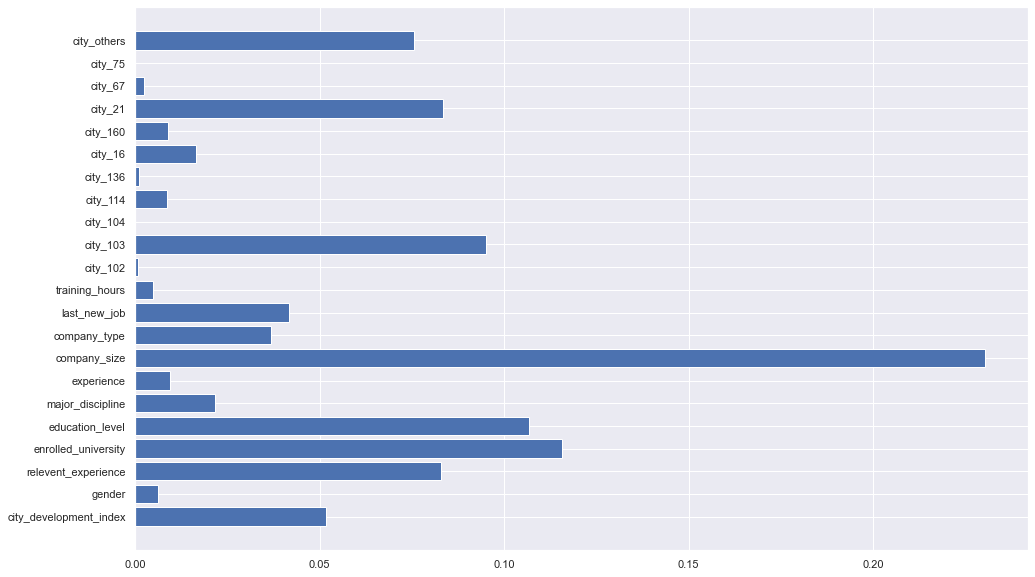

In [148]:
model = trainmodel_os_cv(GradientBoostingClassifier(random_state=43), 5)

fig,ax = plt.subplots(figsize=(16,10))
plt.barh(df.drop('target',axis=1).columns.tolist(), model.feature_importances_)

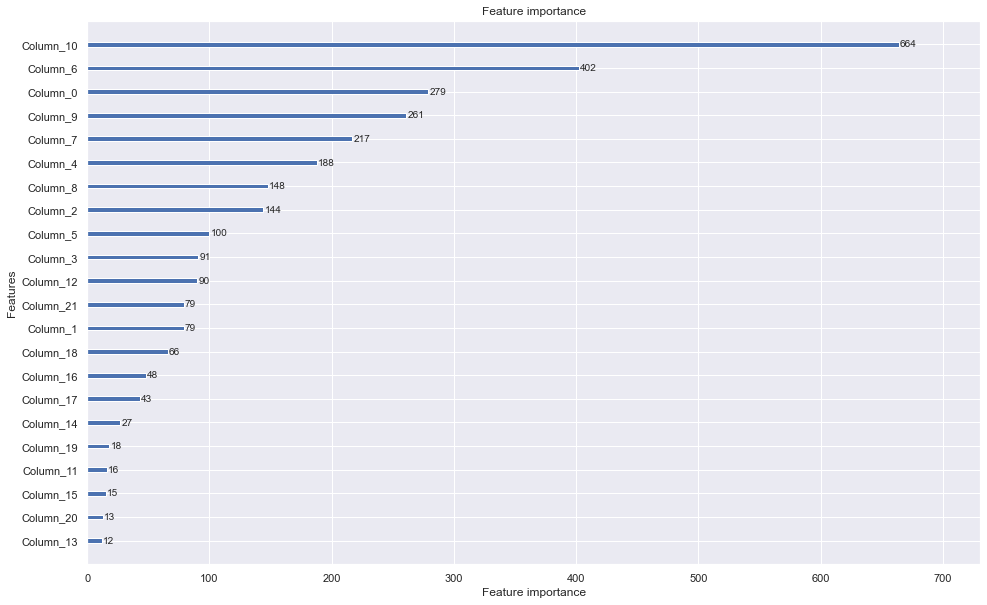

In [149]:
# feature importance for lighgbm
from lightgbm import plot_importance
model = trainmodel_os_cv(lgb.LGBMClassifier(objective='binary',random_state=43),  5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()

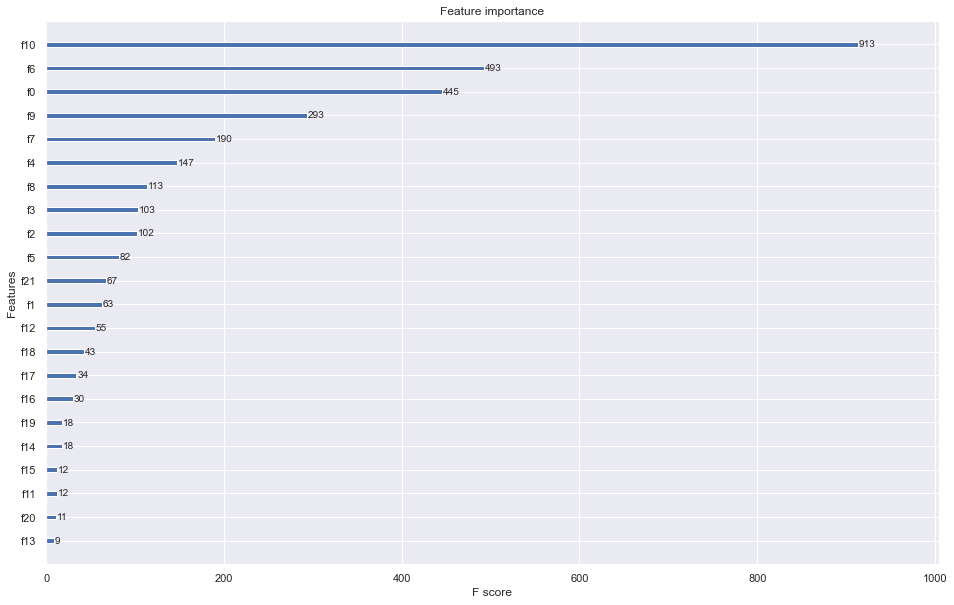

In [150]:
# feature importance for XGB
from xgboost import plot_importance
model = trainmodel_os_cv(XGBClassifier(random_state=43), 5)
fig, ax = plt.subplots(figsize=(16, 10))
plot_importance(model,ax=ax)
plt.show()